In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
os.environ["KERAS_BACKEND"] = "torch"

# Utility libs
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Warnings
import warnings
sns.set_style(style = "whitegrid")

# ML libs
import tensorflow as tf
import torch
import keras_cv
import keras_core as keras

from keras_core import ops

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using PyTorch backend.


In [2]:
os.environ["FOR_TRAINING"] = "True"
os.environ["SEED"] = "42"

os.environ["TRAIN_CSV_PATH"] = "/kaggle/input/UBC-OCEAN/train.csv"
os.environ["TRAIN_IMAGES_PATH"] = "/kaggle/input/UBC-OCEAN/train_images/"
os.environ["TRAIN_THUMBNAIL_IMAGES"] = "/kaggle/input/UBC-OCEAN/train_thumbnails/"

os.environ["BATCH_SIZE"] = "16"
os.environ["LEARNING_RATE"] = "1e-4"
os.environ["EPOCHS"] = "25"

os.environ["TEST_CSV_PATH"] = "/kaggle/input/UBC-OCEAN/test.csv"
os.environ["TEST_IMAGES_PATH"] = "/kaggle/input/UBC-OCEAN/test_images/"
os.environ["TEST_THUMBNAIL_PATH"] = "/kaggle/input/UBC-OCEAN/test_thumbnails"

In [3]:
FOR_TRAINING = bool(os.getenv("FOR_TRAINING"))
SEED = int(os.getenv("SEED"))

TRAIN_CSV_PATH = os.getenv("TRAIN_CSV_PATH")
TRAIN_IMAGES_PATH = os.getenv("TRAIN_IMAGES_PATH")
TRAIN_THUMBNAIL_IMAGES = os.getenv("TRAIN_THUMBNAIL_IMAGES")

BATCH_SIZE = int(os.getenv("BATCH_SIZE"))
LEARNING_RATE = float(os.getenv("LEARNING_RATE"))
EPOCHS = int(os.getenv("EPOCHS"))

TEST_CSV_PATH = os.getenv("TEST_CSV_PATH")
TEST_IMAGES_PATH = os.getenv("TEST_IMAGES_PATH")
TEST_THUMBNAIL_PATH = os.getenv("TEST_THUMBNAIL_PATH")

In [4]:
keras.utils.set_random_seed(seed = SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # 🧭 Device for training (GPU if available, else CPU)

num_rows=538
num_unique_images=538
num_unique_labels=5
unique_labels=array(['HGSC', 'LGSC', 'EC', 'CC', 'MC'], dtype=object)


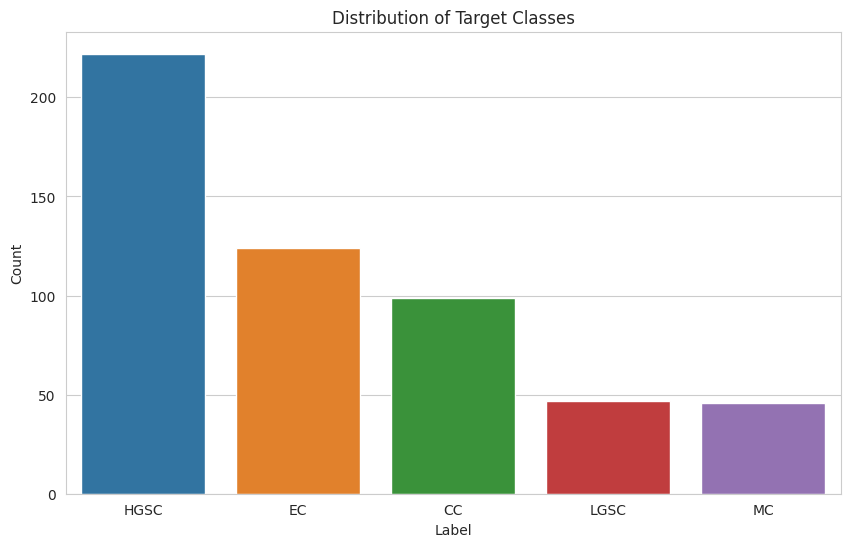

In [5]:
if FOR_TRAINING:
    df = pd.read_csv(TRAIN_CSV_PATH)
    # Get basic statistics about the dataset
    num_rows = df.shape[0]
    num_unique_images = df['image_id'].nunique()
    num_unique_labels = df['label'].nunique()
    unique_labels = df['label'].unique()

    print(f"{num_rows=}")
    print(f"{num_unique_images=}")
    print(f"{num_unique_labels=}")
    print(f"{unique_labels=}")
    
    # Plot the distribution of the target classes
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
    plt.title('Distribution of Target Classes')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

This can also be found using the following code.

Let's take a look at some of the thumbnail images.

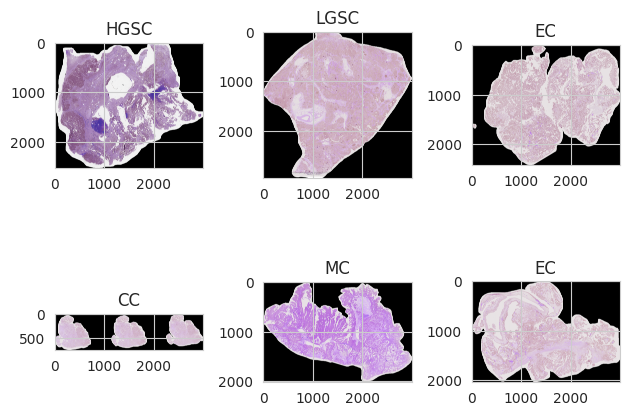

In [6]:
if FOR_TRAINING:    
    num_images_to_plot = 6
    num_rows = 2
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols)
    plot_ids = ["4", "66", "286", "1660", "2227", "10469"]
    plot_labels = ["HGSC", "LGSC", "EC", "CC", "MC", "EC"]
    row = 0
    for img_index in range(num_images_to_plot):
        try_image_index = img_index
        image_name = "/kaggle/input/UBC-OCEAN/train_thumbnails/" + plot_ids[img_index] + "_thumbnail.png"
        label = plot_labels[img_index]
        image = cv2.imread(image_name)

        if img_index % 3 == 0 and img_index != 0:
            row += 1
        axes[row, img_index % num_cols].imshow(image)
        axes[row, img_index % num_cols].set_title(label)

    fig.tight_layout()
    plt.show()

Per the dataset, we have six classes of cancer, one of which is not present in the Training set. Let us one-hot encode all the labels, and another column/attribute of zeros label for the last class, and concatenate the complete one-hot representation to our original DataFrame.

Here is the original DatFrame.

In [7]:
df.head(5)

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


In [8]:
class_dict_1 = {
    "HGSC":0, "LGSC":1, "EC":2, "CC":3, "MC":4
}
class_dict_2 = {
    0:"HGSC", 1:"LGSC", 2:"EC", 3:"CC", 4:"MC"
}
def get_class_labels(labels: list, class_dict = class_dict_1):
    output = list()
    for label in labels:
        num_class_label = class_dict[label]
        output.append(num_class_label)
    return output

### DataLoader, Model, and Training

In [9]:
# Core ML Libs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import resnet50

# Utility ML Libs
import cv2
from skimage import io, transform
from PIL import Image
from tqdm import tqdm

In [10]:
if FOR_TRAINING:
    class OvarianDataset(Dataset):
        def __init__(self, data_df: pd.DataFrame, transforms = None, target_transforms = None):
            self.data_df = data_df
            self.transforms = transforms
            self.target_transforms = target_transforms

        def __len__(self):
            return len(self.data_df)

        def __getitem__(self, idx):
            record_at_idx = df.loc[idx]
            image_path = ""
            if record_at_idx["is_tma"] == False:
                image_path = TRAIN_THUMBNAIL_IMAGES + str(record_at_idx["image_id"]) + "_thumbnail.png"
            else:
                image_path = TRAIN_IMAGES_PATH + str(record_at_idx["image_id"]) + ".png"
            # image_path = TRAIN_IMAGES_PATH + str(record_at_idx["image_id"]) + ".png"
            # print(image_path)
            image = Image.open(image_path)
            label = record_at_idx["label"]

            image_w = record_at_idx["image_width"]
            image_h = record_at_idx["image_height"]

            if self.transforms is not None:
                image = self.transforms(image)

            if self.target_transforms is not None:
                label = self.target_transforms(label)

            sample = {"image": np.array(image), "label": label}

            return sample

In [11]:
if FOR_TRAINING:
    custom_resnet50 = resnet50(weights = True)
    num_classes = 5
    custom_resnet50.fc = nn.Sequential(
        nn.Linear(custom_resnet50.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    custom_resnet50 = custom_resnet50.to(device[0])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


In [12]:
# Weighted Loss
# Given how imabalanced the classes are, 
# we will implement class weighting to ensure generalization across all classes, and sample weighting.
num_images = len(df)
num_hgsc = len(df[df["label"] == "HGSC"])
num_ec = len(df[df["label"] == "EC"])
num_cc = len(df[df["label"] == "CC"])
num_lgsc = len(df[df["label"] == "LGSC"])
num_mc = len(df[df["label"] == "MC"])

# print(f"HGSC: {num_hgsc}")
# print(f"EC: {num_ec}")
# print(f"CC: {num_cc}")
# print(f"LGSC: {num_lgsc}")
# print(f"MC: {num_mc}")

ratio_hgsc = num_hgsc/num_images
ratio_ec = num_ec/num_images
ratio_cc = num_cc/num_images
ratio_lgsc = num_lgsc/num_images
ratio_mc = num_mc/num_images

ratios = np.array([ratio_hgsc, ratio_ec, ratio_cc, ratio_lgsc, ratio_mc])
class_weights = np.ones_like(ratios) - ratios


# Weighted Random Sampling
# Additionally, let us implement sample weighting so that we have a more equal representation of samples across all batches (when I printed the batches earlier, it was a bunch of zeros, i.e. HGSC images).
# Weighted random sampler assigns every image a probability that it would be picked for a batch based on the class it belongs to.

class_counts = df.label.value_counts()
sample_weights = [1/class_counts[label] for label in df.label.values]

sampler = WeightedRandomSampler(weights = sample_weights, num_samples = len(df), replacement = True)

Helper functions to calculate metrics.

In [13]:
classes = np.array([0, 1, 2, 3, 4])
def compute_precision(predicted_labels: np.ndarray, 
                      actual_labels:np.ndarray,
                      class_names = classes):
    """
    Computes the percentage of predicted positives that were actually positive.
    
    predicted_labels: the labels outputted by the model.
    actual_labels: actual labels of the training data
    
    output: true_positives/(true_positives + false_positives)
    """
    
    predicted_labels = predicted_labels.tolist()
    actual_labels = actual_labels.tolist()
    
    # For each class, precision is basically the number of times the model
    # got it right, versus the number of times the model said it was the class
    precision_by_class = list()
    for class_name in class_names:
        num_true_pos = 0
        num_false_pos = 0
        for pred_idx in range(len(predicted_labels)):
            if (predicted_labels[pred_idx] == class_name):
                if (predicted_labels[pred_idx] == actual_labels[pred_idx]):
                    num_true_pos += 1
                else:
                    num_false_pos += 1
                    
        if (num_true_pos + num_false_pos != 0):
            precision = num_true_pos/(num_true_pos + num_false_pos)
            precision_by_class.append(precision)
        
    if len(precision_by_class) == 0:
        return 0.0
    
    precision_by_class = np.array(precision_by_class)
    precision = np.mean(precision_by_class)
    
    return precision

def compute_recall(predicted_labels: np.ndarray, 
                      actual_labels:np.ndarray,
                      class_names = classes):
    """
    Computes the percentage of actual positives that were predicted as positive.
    
    predicted_labels: the labels outputted by the model.
    actual_labels: actual labels of the training data
    
    output: true_positives/(true_positives + false_negatives)
    """
    
    predicted_labels = predicted_labels.tolist()
    actual_labels = actual_labels.tolist()
    
    # For each class, recall is basically the number of times the model
    # got it right, versus the number of times class actually appeared in the batch
    recall_by_class = list()
    for class_name in class_names:
        num_true_pos = 0
        num_false_neg = 0
        for idx in range(len(actual_labels)):
            if (actual_labels[idx] == class_name):
                if (predicted_labels[idx] == actual_labels[idx]):
                    num_true_pos += 1
                else:
                    num_false_neg += 1
                    
        if (num_true_pos + num_false_neg != 0):
            recall = num_true_pos/(num_true_pos + num_false_neg)
            recall_by_class.append(recall)
        
    if len(recall_by_class) == 0:
        return 0.0
    
    recall_by_class = np.array(recall_by_class)
    recall = np.mean(recall_by_class)
    
    return recall


In [14]:
transformation = transforms.Compose(
    [transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
    transforms.RandomRotation(60),
    transforms.RandomHorizontalFlip(0.25),
    transforms.RandomVerticalFlip(0.30)]
)

train_dataset = OvarianDataset(df, transforms = transformation)
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, sampler = sampler)

In [15]:
if FOR_TRAINING:
    class_weights = torch.from_numpy(class_weights).to(device[0], dtype = torch.float32)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(custom_resnet50.parameters(), lr = LEARNING_RATE)
    Image.MAX_IMAGE_PIXELS = None
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1}/{EPOCHS}:\t")
        for batch in tqdm(train_dataloader):
            images, labels = batch["image"].permute(0,3,1,2), batch["label"]

            # preparing the data
            images = images.to(device = device[0], dtype = torch.float32)
            labels = get_class_labels(labels)
            labels = np.array(labels)
            labels = torch.from_numpy(labels).to(device[0])

            # Zeroing the gradient
            optimizer.zero_grad()

            # Forwarding the inputs
            outputs = custom_resnet50(images)

            # Computing the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            predicted_labels = list()
            for elem_idx in range(outputs.size()[0]):
                elem_predictions = outputs[elem_idx, :]
                predicted_class_idx = torch.argmax(elem_predictions)
                predicted_labels.append(predicted_class_idx.cpu().item())

            predicted_labels = np.array(predicted_labels)

            # Preformance Metrics
            labels = np.array(labels.cpu())
            correct_preds = np.sum(labels == predicted_labels)
            total_preds = len(labels)
            accuracy = correct_preds/total_preds * 100
            precision = compute_precision(predicted_labels, labels) * 100
            recall = compute_recall(predicted_labels, labels) * 100
            print(f" loss: {loss}  acc: {accuracy: .2f}% \n precision: {precision: .2f}%  recall: {recall: .2f}%")

Epoch 1/25:	


  3%|▎         | 1/34 [00:06<03:27,  6.28s/it]

 loss: 1.7003161907196045  acc:  18.75% 
 precision:  16.90%  recall:  43.33%


  6%|▌         | 2/34 [00:11<03:00,  5.63s/it]

 loss: 1.699096918106079  acc:  6.25% 
 precision:  5.56%  recall:  8.33%


  9%|▉         | 3/34 [00:15<02:32,  4.93s/it]

 loss: 1.7202562093734741  acc:  12.50% 
 precision:  14.14%  recall:  24.00%


 12%|█▏        | 4/34 [00:20<02:27,  4.90s/it]

 loss: 1.6289979219436646  acc:  25.00% 
 precision:  19.32%  recall:  20.00%


 15%|█▍        | 5/34 [00:25<02:19,  4.82s/it]

 loss: 1.6180715560913086  acc:  31.25% 
 precision:  40.15%  recall:  40.00%


 18%|█▊        | 6/34 [00:30<02:20,  5.01s/it]

 loss: 1.5168970823287964  acc:  25.00% 
 precision:  24.52%  recall:  22.33%


 21%|██        | 7/34 [00:36<02:22,  5.27s/it]

 loss: 1.5876718759536743  acc:  25.00% 
 precision:  19.05%  recall:  16.67%


 24%|██▎       | 8/34 [00:40<02:11,  5.06s/it]

 loss: 1.5084706544876099  acc:  37.50% 
 precision:  32.14%  recall:  30.00%


 26%|██▋       | 9/34 [00:45<02:03,  4.94s/it]

 loss: 1.572231650352478  acc:  25.00% 
 precision:  22.22%  recall:  21.67%


 29%|██▉       | 10/34 [00:49<01:54,  4.76s/it]

 loss: 1.5819969177246094  acc:  37.50% 
 precision:  55.62%  recall:  56.67%


 32%|███▏      | 11/34 [00:55<01:52,  4.87s/it]

 loss: 1.6566541194915771  acc:  12.50% 
 precision:  33.33%  recall:  10.00%


 35%|███▌      | 12/34 [00:59<01:46,  4.83s/it]

 loss: 1.3975656032562256  acc:  43.75% 
 precision:  36.90%  recall:  49.40%


 38%|███▊      | 13/34 [01:03<01:36,  4.58s/it]

 loss: 1.4650352001190186  acc:  31.25% 
 precision:  25.00%  recall:  21.00%


 41%|████      | 14/34 [01:08<01:29,  4.48s/it]

 loss: 1.411297082901001  acc:  43.75% 
 precision:  25.00%  recall:  26.67%


 44%|████▍     | 15/34 [01:12<01:27,  4.63s/it]

 loss: 1.5701402425765991  acc:  25.00% 
 precision:  37.78%  recall:  40.00%


 47%|████▋     | 16/34 [01:17<01:21,  4.52s/it]

 loss: 1.5403121709823608  acc:  31.25% 
 precision:  30.00%  recall:  40.00%


 50%|█████     | 17/34 [01:21<01:12,  4.29s/it]

 loss: 1.591538667678833  acc:  25.00% 
 precision:  35.56%  recall:  50.00%


 53%|█████▎    | 18/34 [01:25<01:11,  4.49s/it]

 loss: 1.5930893421173096  acc:  18.75% 
 precision:  45.00%  recall:  28.00%


 56%|█████▌    | 19/34 [01:30<01:08,  4.56s/it]

 loss: 1.381720781326294  acc:  56.25% 
 precision:  68.33%  recall:  53.33%


 59%|█████▉    | 20/34 [01:35<01:04,  4.59s/it]

 loss: 1.5308198928833008  acc:  37.50% 
 precision:  50.71%  recall:  42.38%


 62%|██████▏   | 21/34 [01:40<01:00,  4.69s/it]

 loss: 1.408583641052246  acc:  25.00% 
 precision:  18.67%  recall:  23.33%


 65%|██████▍   | 22/34 [01:45<00:57,  4.80s/it]

 loss: 1.3496105670928955  acc:  43.75% 
 precision:  33.33%  recall:  32.67%


 68%|██████▊   | 23/34 [01:49<00:50,  4.55s/it]

 loss: 1.3736697435379028  acc:  18.75% 
 precision:  14.58%  recall:  26.67%


 71%|███████   | 24/34 [01:53<00:45,  4.59s/it]

 loss: 1.5579286813735962  acc:  37.50% 
 precision:  27.50%  recall:  28.57%


 74%|███████▎  | 25/34 [01:58<00:42,  4.70s/it]

 loss: 1.2437305450439453  acc:  62.50% 
 precision:  60.00%  recall:  56.67%


 76%|███████▋  | 26/34 [02:04<00:38,  4.83s/it]

 loss: 1.4101234674453735  acc:  31.25% 
 precision:  52.50%  recall:  25.00%


 79%|███████▉  | 27/34 [02:08<00:32,  4.62s/it]

 loss: 1.3961842060089111  acc:  50.00% 
 precision:  60.00%  recall:  50.00%


 82%|████████▏ | 28/34 [02:12<00:26,  4.48s/it]

 loss: 1.4271693229675293  acc:  37.50% 
 precision:  53.81%  recall:  43.33%


 85%|████████▌ | 29/34 [02:16<00:21,  4.38s/it]

 loss: 1.2996681928634644  acc:  31.25% 
 precision:  30.00%  recall:  30.00%


 88%|████████▊ | 30/34 [02:21<00:17,  4.47s/it]

 loss: 1.2689850330352783  acc:  50.00% 
 precision:  43.33%  recall:  35.00%


 91%|█████████ | 31/34 [02:25<00:13,  4.43s/it]

 loss: 1.3577876091003418  acc:  37.50% 
 precision:  51.67%  recall:  51.67%


 94%|█████████▍| 32/34 [02:29<00:08,  4.41s/it]

 loss: 1.366390347480774  acc:  56.25% 
 precision:  60.83%  recall:  55.33%


 97%|█████████▋| 33/34 [02:34<00:04,  4.35s/it]

 loss: 1.1249281167984009  acc:  56.25% 
 precision:  70.71%  recall:  53.33%


100%|██████████| 34/34 [02:36<00:00,  4.60s/it]


 loss: 1.4802507162094116  acc:  40.00% 
 precision:  47.92%  recall:  45.83%
Epoch 2/25:	


  3%|▎         | 1/34 [00:04<02:24,  4.38s/it]

 loss: 1.1527470350265503  acc:  56.25% 
 precision:  56.25%  recall:  55.33%


  6%|▌         | 2/34 [00:09<02:26,  4.59s/it]

 loss: 1.460349202156067  acc:  43.75% 
 precision:  38.33%  recall:  47.92%


  9%|▉         | 3/34 [00:13<02:20,  4.53s/it]

 loss: 1.2393102645874023  acc:  37.50% 
 precision:  36.67%  recall:  46.67%


 12%|█▏        | 4/34 [00:18<02:19,  4.65s/it]

 loss: 1.0266212224960327  acc:  62.50% 
 precision:  65.36%  recall:  54.29%


 15%|█▍        | 5/34 [00:23<02:17,  4.75s/it]

 loss: 1.4705755710601807  acc:  31.25% 
 precision:  37.50%  recall:  41.33%


 18%|█▊        | 6/34 [00:27<02:09,  4.62s/it]

 loss: 1.4457677602767944  acc:  31.25% 
 precision:  50.00%  recall:  20.71%


 21%|██        | 7/34 [00:32<02:03,  4.57s/it]

 loss: 1.2313435077667236  acc:  50.00% 
 precision:  44.00%  recall:  46.67%


 24%|██▎       | 8/34 [00:37<02:03,  4.75s/it]

 loss: 1.3708890676498413  acc:  43.75% 
 precision:  51.49%  recall:  55.00%


 26%|██▋       | 9/34 [00:41<01:56,  4.65s/it]

 loss: 1.4615660905838013  acc:  31.25% 
 precision:  50.00%  recall:  25.33%


 29%|██▉       | 10/34 [00:45<01:48,  4.51s/it]

 loss: 1.0218733549118042  acc:  56.25% 
 precision:  51.67%  recall:  43.00%


 32%|███▏      | 11/34 [00:49<01:40,  4.37s/it]

 loss: 1.403586745262146  acc:  43.75% 
 precision:  54.00%  recall:  55.95%


 35%|███▌      | 12/34 [00:54<01:38,  4.48s/it]

 loss: 1.3116599321365356  acc:  37.50% 
 precision:  30.00%  recall:  25.00%


 38%|███▊      | 13/34 [00:58<01:31,  4.38s/it]

 loss: 1.2638659477233887  acc:  62.50% 
 precision:  60.00%  recall:  77.33%


 41%|████      | 14/34 [01:02<01:26,  4.31s/it]

 loss: 1.0956159830093384  acc:  62.50% 
 precision:  61.67%  recall:  72.00%


 44%|████▍     | 15/34 [01:07<01:20,  4.22s/it]

 loss: 1.0001451969146729  acc:  62.50% 
 precision:  70.00%  recall:  63.33%


 47%|████▋     | 16/34 [01:10<01:14,  4.11s/it]

 loss: 1.1893649101257324  acc:  56.25% 
 precision:  47.33%  recall:  59.33%


 50%|█████     | 17/34 [01:15<01:13,  4.32s/it]

 loss: 0.9368954300880432  acc:  56.25% 
 precision:  53.33%  recall:  48.67%


 53%|█████▎    | 18/34 [01:19<01:08,  4.31s/it]

 loss: 1.099442481994629  acc:  56.25% 
 precision:  52.00%  recall:  60.83%


 56%|█████▌    | 19/34 [01:24<01:06,  4.40s/it]

 loss: 1.1224499940872192  acc:  62.50% 
 precision:  53.81%  recall:  58.33%


 59%|█████▉    | 20/34 [01:28<00:59,  4.26s/it]

 loss: 1.63127601146698  acc:  31.25% 
 precision:  32.00%  recall:  46.67%


 62%|██████▏   | 21/34 [01:33<00:58,  4.48s/it]

 loss: 1.154954195022583  acc:  50.00% 
 precision:  41.00%  recall:  36.00%


 65%|██████▍   | 22/34 [01:38<00:53,  4.50s/it]

 loss: 0.851612389087677  acc:  68.75% 
 precision:  55.00%  recall:  57.14%


 68%|██████▊   | 23/34 [01:42<00:48,  4.43s/it]

 loss: 1.2590023279190063  acc:  50.00% 
 precision:  58.33%  recall:  50.00%


 71%|███████   | 24/34 [01:45<00:41,  4.13s/it]

 loss: 1.2836475372314453  acc:  56.25% 
 precision:  41.33%  recall:  60.00%


 74%|███████▎  | 25/34 [01:49<00:36,  4.09s/it]

 loss: 1.1430014371871948  acc:  56.25% 
 precision:  58.67%  recall:  60.00%


 76%|███████▋  | 26/34 [01:54<00:34,  4.33s/it]

 loss: 0.7140466570854187  acc:  62.50% 
 precision:  58.33%  recall:  66.67%


 79%|███████▉  | 27/34 [01:58<00:29,  4.18s/it]

 loss: 1.1047037839889526  acc:  62.50% 
 precision:  72.67%  recall:  66.00%


 82%|████████▏ | 28/34 [02:02<00:24,  4.16s/it]

 loss: 1.2232714891433716  acc:  50.00% 
 precision:  48.33%  recall:  55.00%


 85%|████████▌ | 29/34 [02:06<00:20,  4.19s/it]

 loss: 1.3925467729568481  acc:  50.00% 
 precision:  55.00%  recall:  56.33%


 88%|████████▊ | 30/34 [02:11<00:16,  4.24s/it]

 loss: 1.4633073806762695  acc:  68.75% 
 precision:  71.00%  recall:  64.33%


 91%|█████████ | 31/34 [02:15<00:12,  4.23s/it]

 loss: 0.9652184247970581  acc:  62.50% 
 precision:  56.67%  recall:  58.33%


 94%|█████████▍| 32/34 [02:20<00:08,  4.49s/it]

 loss: 0.9849883913993835  acc:  68.75% 
 precision:  79.00%  recall:  81.67%


 97%|█████████▋| 33/34 [02:24<00:04,  4.31s/it]

 loss: 1.0685102939605713  acc:  68.75% 
 precision:  73.33%  recall:  72.00%


100%|██████████| 34/34 [02:26<00:00,  4.31s/it]


 loss: 1.5708591938018799  acc:  60.00% 
 precision:  62.50%  recall:  63.33%
Epoch 3/25:	


  3%|▎         | 1/34 [00:05<02:53,  5.25s/it]

 loss: 1.0757191181182861  acc:  62.50% 
 precision:  70.67%  recall:  64.33%


  6%|▌         | 2/34 [00:10<02:42,  5.08s/it]

 loss: 0.9795329570770264  acc:  56.25% 
 precision:  55.33%  recall:  61.67%


  9%|▉         | 3/34 [00:14<02:20,  4.53s/it]

 loss: 0.9067346453666687  acc:  68.75% 
 precision:  75.00%  recall:  66.67%


 12%|█▏        | 4/34 [00:19<02:30,  5.03s/it]

 loss: 0.8547148704528809  acc:  68.75% 
 precision:  72.50%  recall:  64.76%


 15%|█▍        | 5/34 [00:23<02:16,  4.70s/it]

 loss: 1.271620273590088  acc:  50.00% 
 precision:  50.00%  recall:  50.00%


 18%|█▊        | 6/34 [00:28<02:12,  4.73s/it]

 loss: 1.159037709236145  acc:  43.75% 
 precision:  40.00%  recall:  47.00%


 21%|██        | 7/34 [00:33<02:11,  4.86s/it]

 loss: 1.03679358959198  acc:  75.00% 
 precision:  78.33%  recall:  76.67%


 24%|██▎       | 8/34 [00:38<02:00,  4.62s/it]

 loss: 0.9752978682518005  acc:  56.25% 
 precision:  61.00%  recall:  66.67%


 26%|██▋       | 9/34 [00:42<01:54,  4.57s/it]

 loss: 1.3012582063674927  acc:  50.00% 
 precision:  50.00%  recall:  59.00%


 29%|██▉       | 10/34 [00:46<01:49,  4.56s/it]

 loss: 0.9347186088562012  acc:  62.50% 
 precision:  70.83%  recall:  57.33%


 32%|███▏      | 11/34 [00:51<01:42,  4.44s/it]

 loss: 1.0300668478012085  acc:  50.00% 
 precision:  53.33%  recall:  55.00%


 35%|███▌      | 12/34 [00:55<01:35,  4.34s/it]

 loss: 1.0677134990692139  acc:  62.50% 
 precision:  68.33%  recall:  53.33%


 38%|███▊      | 13/34 [00:58<01:27,  4.15s/it]

 loss: 1.3099721670150757  acc:  31.25% 
 precision:  39.00%  recall:  44.00%


 41%|████      | 14/34 [01:02<01:22,  4.11s/it]

 loss: 1.189157485961914  acc:  37.50% 
 precision:  38.33%  recall:  54.00%


 44%|████▍     | 15/34 [01:08<01:23,  4.39s/it]

 loss: 0.9156970381736755  acc:  56.25% 
 precision:  52.08%  recall:  56.67%


 47%|████▋     | 16/34 [01:12<01:17,  4.33s/it]

 loss: 0.7064841985702515  acc:  68.75% 
 precision:  66.67%  recall:  56.00%


 50%|█████     | 17/34 [01:15<01:10,  4.14s/it]

 loss: 1.2801917791366577  acc:  43.75% 
 precision:  45.00%  recall:  38.33%


 53%|█████▎    | 18/34 [01:20<01:08,  4.29s/it]

 loss: 1.4280555248260498  acc:  37.50% 
 precision:  40.00%  recall:  47.33%


 56%|█████▌    | 19/34 [01:24<01:04,  4.30s/it]

 loss: 1.150913953781128  acc:  62.50% 
 precision:  64.33%  recall:  60.83%


 59%|█████▉    | 20/34 [01:29<00:59,  4.27s/it]

 loss: 1.0786466598510742  acc:  68.75% 
 precision:  63.33%  recall:  71.88%


 62%|██████▏   | 21/34 [01:32<00:52,  4.06s/it]

 loss: 0.9803904294967651  acc:  81.25% 
 precision:  76.67%  recall:  85.00%


 65%|██████▍   | 22/34 [01:37<00:50,  4.20s/it]

 loss: 1.006574034690857  acc:  43.75% 
 precision:  52.33%  recall:  55.67%


 68%|██████▊   | 23/34 [01:41<00:48,  4.37s/it]

 loss: 1.0610404014587402  acc:  56.25% 
 precision:  60.67%  recall:  52.67%


 71%|███████   | 24/34 [01:46<00:43,  4.38s/it]

 loss: 1.068518042564392  acc:  62.50% 
 precision:  55.00%  recall:  58.67%


 74%|███████▎  | 25/34 [01:50<00:39,  4.34s/it]

 loss: 0.8362149596214294  acc:  75.00% 
 precision:  73.33%  recall:  63.33%


 76%|███████▋  | 26/34 [01:54<00:33,  4.24s/it]

 loss: 0.7891286015510559  acc:  68.75% 
 precision:  71.67%  recall:  74.67%


 79%|███████▉  | 27/34 [01:58<00:29,  4.27s/it]

 loss: 0.8695805072784424  acc:  62.50% 
 precision:  61.67%  recall:  52.00%


 82%|████████▏ | 28/34 [02:02<00:24,  4.14s/it]

 loss: 1.316762924194336  acc:  50.00% 
 precision:  43.33%  recall:  53.33%


 85%|████████▌ | 29/34 [02:06<00:19,  3.88s/it]

 loss: 1.2387760877609253  acc:  62.50% 
 precision:  55.00%  recall:  60.83%


 88%|████████▊ | 30/34 [02:10<00:16,  4.06s/it]

 loss: 1.09541916847229  acc:  62.50% 
 precision:  50.00%  recall:  72.22%


 91%|█████████ | 31/34 [02:14<00:12,  4.05s/it]

 loss: 1.2231905460357666  acc:  56.25% 
 precision:  50.00%  recall:  60.00%


 94%|█████████▍| 32/34 [02:18<00:08,  4.14s/it]

 loss: 1.282780408859253  acc:  56.25% 
 precision:  46.67%  recall:  48.00%


 97%|█████████▋| 33/34 [02:23<00:04,  4.18s/it]

 loss: 1.1315875053405762  acc:  56.25% 
 precision:  47.67%  recall:  48.00%


100%|██████████| 34/34 [02:25<00:00,  4.29s/it]


 loss: 1.764696717262268  acc:  30.00% 
 precision:  23.33%  recall:  50.00%
Epoch 4/25:	


  3%|▎         | 1/34 [00:04<02:36,  4.75s/it]

 loss: 0.7939276099205017  acc:  87.50% 
 precision:  90.18%  recall:  87.50%


  6%|▌         | 2/34 [00:09<02:35,  4.85s/it]

 loss: 0.9342382550239563  acc:  75.00% 
 precision:  75.00%  recall:  75.00%


  9%|▉         | 3/34 [00:14<02:30,  4.85s/it]

 loss: 0.8457178473472595  acc:  62.50% 
 precision:  66.67%  recall:  55.48%


 12%|█▏        | 4/34 [00:17<02:07,  4.25s/it]

 loss: 1.399978756904602  acc:  43.75% 
 precision:  46.67%  recall:  42.67%


 15%|█▍        | 5/34 [00:22<02:06,  4.35s/it]

 loss: 1.1326415538787842  acc:  56.25% 
 precision:  73.57%  recall:  63.33%


 18%|█▊        | 6/34 [00:26<01:57,  4.20s/it]

 loss: 1.1958441734313965  acc:  43.75% 
 precision:  51.67%  recall:  48.75%


 21%|██        | 7/34 [00:30<01:53,  4.21s/it]

 loss: 0.7271168231964111  acc:  81.25% 
 precision:  84.33%  recall:  84.33%


 24%|██▎       | 8/34 [00:35<01:52,  4.33s/it]

 loss: 1.1177655458450317  acc:  62.50% 
 precision:  59.33%  recall:  66.00%


 26%|██▋       | 9/34 [00:38<01:43,  4.14s/it]

 loss: 1.0829805135726929  acc:  56.25% 
 precision:  57.33%  recall:  54.67%


 29%|██▉       | 10/34 [00:42<01:37,  4.05s/it]

 loss: 0.8112444281578064  acc:  62.50% 
 precision:  55.00%  recall:  66.67%


 32%|███▏      | 11/34 [00:46<01:32,  4.00s/it]

 loss: 1.2476729154586792  acc:  50.00% 
 precision:  59.33%  recall:  42.67%


 35%|███▌      | 12/34 [00:50<01:27,  3.97s/it]

 loss: 1.1869494915008545  acc:  50.00% 
 precision:  55.00%  recall:  68.33%


 38%|███▊      | 13/34 [00:54<01:21,  3.89s/it]

 loss: 0.7458527684211731  acc:  81.25% 
 precision:  87.00%  recall:  85.33%


 41%|████      | 14/34 [00:58<01:20,  4.02s/it]

 loss: 0.8471486568450928  acc:  62.50% 
 precision:  55.33%  recall:  56.67%


 44%|████▍     | 15/34 [01:02<01:17,  4.09s/it]

 loss: 0.7028651833534241  acc:  81.25% 
 precision:  85.00%  recall:  85.00%


 47%|████▋     | 16/34 [01:06<01:11,  3.95s/it]

 loss: 1.220144510269165  acc:  56.25% 
 precision:  55.00%  recall:  60.00%


 50%|█████     | 17/34 [01:10<01:07,  3.96s/it]

 loss: 0.9538879990577698  acc:  62.50% 
 precision:  56.67%  recall:  55.00%


 53%|█████▎    | 18/34 [01:14<01:03,  3.95s/it]

 loss: 0.86252760887146  acc:  62.50% 
 precision:  76.67%  recall:  71.43%


 56%|█████▌    | 19/34 [01:18<00:58,  3.93s/it]

 loss: 1.2109375  acc:  56.25% 
 precision:  65.67%  recall:  56.33%


 59%|█████▉    | 20/34 [01:21<00:54,  3.89s/it]

 loss: 1.1175075769424438  acc:  56.25% 
 precision:  56.67%  recall:  61.67%


 62%|██████▏   | 21/34 [01:26<00:54,  4.18s/it]

 loss: 1.0219639539718628  acc:  62.50% 
 precision:  62.00%  recall:  72.00%


 65%|██████▍   | 22/34 [01:32<00:54,  4.54s/it]

 loss: 0.9678608775138855  acc:  75.00% 
 precision:  71.67%  recall:  77.62%


 68%|██████▊   | 23/34 [01:36<00:50,  4.61s/it]

 loss: 1.036952257156372  acc:  75.00% 
 precision:  76.00%  recall:  72.67%


 71%|███████   | 24/34 [01:42<00:48,  4.84s/it]

 loss: 1.003317952156067  acc:  68.75% 
 precision:  77.00%  recall:  73.67%


 74%|███████▎  | 25/34 [01:46<00:41,  4.59s/it]

 loss: 1.0055629014968872  acc:  62.50% 
 precision:  62.00%  recall:  62.00%


 76%|███████▋  | 26/34 [01:50<00:36,  4.56s/it]

 loss: 0.9595209360122681  acc:  68.75% 
 precision:  75.33%  recall:  75.00%


 79%|███████▉  | 27/34 [01:54<00:31,  4.44s/it]

 loss: 0.8392751216888428  acc:  68.75% 
 precision:  66.67%  recall:  71.33%


 82%|████████▏ | 28/34 [01:59<00:26,  4.35s/it]

 loss: 1.298658847808838  acc:  43.75% 
 precision:  33.33%  recall:  25.33%


 85%|████████▌ | 29/34 [02:02<00:20,  4.01s/it]

 loss: 0.8773983716964722  acc:  62.50% 
 precision:  55.00%  recall:  55.33%


 88%|████████▊ | 30/34 [02:07<00:17,  4.36s/it]

 loss: 0.9074135422706604  acc:  68.75% 
 precision:  56.67%  recall:  61.67%


 91%|█████████ | 31/34 [02:11<00:12,  4.31s/it]

 loss: 1.289726734161377  acc:  62.50% 
 precision:  66.67%  recall:  77.33%


 94%|█████████▍| 32/34 [02:15<00:08,  4.29s/it]

 loss: 0.9724138379096985  acc:  62.50% 
 precision:  75.24%  recall:  70.67%


 97%|█████████▋| 33/34 [02:19<00:04,  4.11s/it]

 loss: 0.9947452545166016  acc:  50.00% 
 precision:  46.67%  recall:  53.57%


100%|██████████| 34/34 [02:22<00:00,  4.18s/it]


 loss: 0.3630807399749756  acc:  100.00% 
 precision:  100.00%  recall:  100.00%
Epoch 5/25:	


  3%|▎         | 1/34 [00:04<02:17,  4.15s/it]

 loss: 1.4079594612121582  acc:  50.00% 
 precision:  43.33%  recall:  52.38%


  6%|▌         | 2/34 [00:07<01:57,  3.66s/it]

 loss: 0.9436569809913635  acc:  50.00% 
 precision:  59.00%  recall:  56.67%


  9%|▉         | 3/34 [00:12<02:10,  4.21s/it]

 loss: 1.2537380456924438  acc:  43.75% 
 precision:  48.33%  recall:  43.33%


 12%|█▏        | 4/34 [00:16<02:01,  4.05s/it]

 loss: 0.8452189564704895  acc:  62.50% 
 precision:  56.67%  recall:  66.67%


 15%|█▍        | 5/34 [00:20<02:05,  4.33s/it]

 loss: 0.8675616383552551  acc:  68.75% 
 precision:  56.00%  recall:  59.33%


 18%|█▊        | 6/34 [00:25<01:59,  4.25s/it]

 loss: 1.0889999866485596  acc:  62.50% 
 precision:  62.00%  recall:  72.33%


 21%|██        | 7/34 [00:29<01:59,  4.43s/it]

 loss: 0.8499869704246521  acc:  68.75% 
 precision:  71.00%  recall:  65.00%


 24%|██▎       | 8/34 [00:34<01:53,  4.36s/it]

 loss: 0.788249135017395  acc:  62.50% 
 precision:  71.67%  recall:  67.33%


 26%|██▋       | 9/34 [00:39<01:54,  4.59s/it]

 loss: 0.9418812990188599  acc:  62.50% 
 precision:  64.67%  recall:  66.67%


 29%|██▉       | 10/34 [00:42<01:43,  4.30s/it]

 loss: 1.7090444564819336  acc:  37.50% 
 precision:  40.00%  recall:  35.95%


 32%|███▏      | 11/34 [00:47<01:39,  4.32s/it]

 loss: 0.9793471097946167  acc:  50.00% 
 precision:  69.52%  recall:  57.00%


 35%|███▌      | 12/34 [00:51<01:32,  4.19s/it]

 loss: 0.810106635093689  acc:  68.75% 
 precision:  68.67%  recall:  73.33%


 38%|███▊      | 13/34 [00:55<01:28,  4.20s/it]

 loss: 1.4341423511505127  acc:  31.25% 
 precision:  24.67%  recall:  36.31%


 41%|████      | 14/34 [00:59<01:25,  4.27s/it]

 loss: 0.8904942274093628  acc:  62.50% 
 precision:  58.33%  recall:  69.29%


 44%|████▍     | 15/34 [01:03<01:17,  4.07s/it]

 loss: 0.5920969843864441  acc:  75.00% 
 precision:  83.04%  recall:  80.00%


 47%|████▋     | 16/34 [01:06<01:09,  3.89s/it]

 loss: 1.4679903984069824  acc:  37.50% 
 precision:  39.67%  recall:  42.33%


 50%|█████     | 17/34 [01:10<01:06,  3.90s/it]

 loss: 1.136393427848816  acc:  68.75% 
 precision:  75.00%  recall:  72.67%


 53%|█████▎    | 18/34 [01:14<01:02,  3.92s/it]

 loss: 1.0850731134414673  acc:  62.50% 
 precision:  65.33%  recall:  76.00%


 56%|█████▌    | 19/34 [01:18<00:59,  3.97s/it]

 loss: 0.8371363282203674  acc:  68.75% 
 precision:  63.33%  recall:  70.00%


 59%|█████▉    | 20/34 [01:22<00:55,  3.94s/it]

 loss: 0.8449389934539795  acc:  68.75% 
 precision:  72.00%  recall:  70.00%


 62%|██████▏   | 21/34 [01:27<00:53,  4.14s/it]

 loss: 0.7726500630378723  acc:  68.75% 
 precision:  73.33%  recall:  77.33%


 65%|██████▍   | 22/34 [01:31<00:50,  4.18s/it]

 loss: 0.8586335182189941  acc:  75.00% 
 precision:  78.33%  recall:  82.50%


 68%|██████▊   | 23/34 [01:35<00:46,  4.23s/it]

 loss: 0.7402881979942322  acc:  68.75% 
 precision:  56.67%  recall:  54.29%


 71%|███████   | 24/34 [01:40<00:42,  4.30s/it]

 loss: 0.8188235759735107  acc:  75.00% 
 precision:  73.33%  recall:  73.33%


 74%|███████▎  | 25/34 [01:45<00:39,  4.44s/it]

 loss: 0.8029665946960449  acc:  62.50% 
 precision:  66.67%  recall:  73.33%


 76%|███████▋  | 26/34 [01:49<00:34,  4.33s/it]

 loss: 0.8492569327354431  acc:  75.00% 
 precision:  81.33%  recall:  75.00%


 79%|███████▉  | 27/34 [01:53<00:29,  4.22s/it]

 loss: 0.6781010031700134  acc:  75.00% 
 precision:  73.33%  recall:  78.33%


 82%|████████▏ | 28/34 [01:57<00:25,  4.25s/it]

 loss: 0.8509061932563782  acc:  68.75% 
 precision:  74.67%  recall:  72.00%


 85%|████████▌ | 29/34 [02:01<00:21,  4.22s/it]

 loss: 1.188623070716858  acc:  50.00% 
 precision:  33.33%  recall:  40.00%


 88%|████████▊ | 30/34 [02:04<00:15,  3.94s/it]

 loss: 0.9307641386985779  acc:  56.25% 
 precision:  53.33%  recall:  55.00%


 91%|█████████ | 31/34 [02:08<00:11,  3.88s/it]

 loss: 0.7261561751365662  acc:  75.00% 
 precision:  83.33%  recall:  76.67%


 94%|█████████▍| 32/34 [02:13<00:08,  4.16s/it]

 loss: 1.2138512134552002  acc:  43.75% 
 precision:  66.67%  recall:  56.25%


 97%|█████████▋| 33/34 [02:17<00:04,  4.22s/it]

 loss: 0.6084601879119873  acc:  81.25% 
 precision:  81.00%  recall:  82.00%


100%|██████████| 34/34 [02:20<00:00,  4.13s/it]


 loss: 1.0920180082321167  acc:  60.00% 
 precision:  60.00%  recall:  72.50%
Epoch 6/25:	


  3%|▎         | 1/34 [00:04<02:38,  4.80s/it]

 loss: 0.7171120643615723  acc:  81.25% 
 precision:  80.00%  recall:  78.33%


  6%|▌         | 2/34 [00:08<02:20,  4.40s/it]

 loss: 0.8057271838188171  acc:  75.00% 
 precision:  68.00%  recall:  77.50%


  9%|▉         | 3/34 [00:12<02:04,  4.03s/it]

 loss: 0.5131141543388367  acc:  93.75% 
 precision:  93.33%  recall:  93.33%


 12%|█▏        | 4/34 [00:17<02:06,  4.22s/it]

 loss: 0.6925457119941711  acc:  87.50% 
 precision:  75.00%  recall:  73.33%


 15%|█▍        | 5/34 [00:21<02:04,  4.29s/it]

 loss: 1.0867482423782349  acc:  50.00% 
 precision:  47.00%  recall:  48.67%


 18%|█▊        | 6/34 [00:25<01:55,  4.12s/it]

 loss: 0.7008266448974609  acc:  75.00% 
 precision:  84.00%  recall:  75.33%


 21%|██        | 7/34 [00:29<01:51,  4.14s/it]

 loss: 0.7400844693183899  acc:  75.00% 
 precision:  73.33%  recall:  83.33%


 24%|██▎       | 8/34 [00:33<01:47,  4.15s/it]

 loss: 0.7030817866325378  acc:  68.75% 
 precision:  72.00%  recall:  71.67%


 26%|██▋       | 9/34 [00:37<01:43,  4.12s/it]

 loss: 1.5556385517120361  acc:  43.75% 
 precision:  48.57%  recall:  53.17%


 29%|██▉       | 10/34 [00:41<01:39,  4.15s/it]

 loss: 0.8360475897789001  acc:  75.00% 
 precision:  85.00%  recall:  75.00%


 32%|███▏      | 11/34 [00:45<01:33,  4.09s/it]

 loss: 1.0289727449417114  acc:  56.25% 
 precision:  45.71%  recall:  55.83%


 35%|███▌      | 12/34 [00:50<01:35,  4.32s/it]

 loss: 1.15016508102417  acc:  50.00% 
 precision:  53.00%  recall:  43.33%


 38%|███▊      | 13/34 [00:54<01:30,  4.32s/it]

 loss: 0.6631236672401428  acc:  81.25% 
 precision:  88.00%  recall:  82.67%


 41%|████      | 14/34 [00:58<01:24,  4.22s/it]

 loss: 0.4608671963214874  acc:  87.50% 
 precision:  86.67%  recall:  85.00%


 44%|████▍     | 15/34 [01:02<01:17,  4.06s/it]

 loss: 0.7008609175682068  acc:  68.75% 
 precision:  70.00%  recall:  72.67%


 47%|████▋     | 16/34 [01:06<01:10,  3.93s/it]

 loss: 1.3129914999008179  acc:  43.75% 
 precision:  43.33%  recall:  43.00%


 50%|█████     | 17/34 [01:10<01:10,  4.13s/it]

 loss: 0.8526307940483093  acc:  62.50% 
 precision:  54.67%  recall:  54.29%


 53%|█████▎    | 18/34 [01:14<01:05,  4.11s/it]

 loss: 0.7047899961471558  acc:  75.00% 
 precision:  63.33%  recall:  72.92%


 56%|█████▌    | 19/34 [01:19<01:01,  4.10s/it]

 loss: 1.1018531322479248  acc:  56.25% 
 precision:  53.33%  recall:  67.38%


 59%|█████▉    | 20/34 [01:22<00:55,  4.00s/it]

 loss: 0.6522982716560364  acc:  87.50% 
 precision:  90.00%  recall:  83.33%


 62%|██████▏   | 21/34 [01:26<00:51,  3.97s/it]

 loss: 0.5652498602867126  acc:  87.50% 
 precision:  80.00%  recall:  90.83%


 65%|██████▍   | 22/34 [01:30<00:46,  3.92s/it]

 loss: 0.9883376955986023  acc:  56.25% 
 precision:  56.67%  recall:  69.44%


 68%|██████▊   | 23/34 [01:34<00:45,  4.09s/it]

 loss: 0.5530992746353149  acc:  81.25% 
 precision:  88.00%  recall:  81.67%


 71%|███████   | 24/34 [01:37<00:37,  3.76s/it]

 loss: 1.1143854856491089  acc:  56.25% 
 precision:  57.00%  recall:  52.33%


 74%|███████▎  | 25/34 [01:42<00:35,  3.93s/it]

 loss: 0.7345169186592102  acc:  75.00% 
 precision:  74.33%  recall:  81.67%


 76%|███████▋  | 26/34 [01:46<00:31,  3.88s/it]

 loss: 1.4336156845092773  acc:  56.25% 
 precision:  46.67%  recall:  54.17%


 79%|███████▉  | 27/34 [01:50<00:27,  3.99s/it]

 loss: 1.0106947422027588  acc:  56.25% 
 precision:  63.57%  recall:  65.00%


 82%|████████▏ | 28/34 [01:54<00:23,  3.95s/it]

 loss: 0.950761079788208  acc:  50.00% 
 precision:  50.00%  recall:  56.67%


 85%|████████▌ | 29/34 [01:57<00:19,  3.87s/it]

 loss: 0.9916896224021912  acc:  62.50% 
 precision:  64.67%  recall:  59.33%


 88%|████████▊ | 30/34 [02:01<00:15,  3.80s/it]

 loss: 0.6870599389076233  acc:  68.75% 
 precision:  68.00%  recall:  70.00%


 91%|█████████ | 31/34 [02:05<00:11,  3.91s/it]

 loss: 0.6744088530540466  acc:  81.25% 
 precision:  80.00%  recall:  89.33%


 94%|█████████▍| 32/34 [02:10<00:08,  4.10s/it]

 loss: 0.987225353717804  acc:  68.75% 
 precision:  80.00%  recall:  77.00%


 97%|█████████▋| 33/34 [02:13<00:03,  3.93s/it]

 loss: 0.4920161962509155  acc:  75.00% 
 precision:  76.00%  recall:  83.33%


100%|██████████| 34/34 [02:15<00:00,  4.00s/it]


 loss: 1.1662137508392334  acc:  50.00% 
 precision:  56.67%  recall:  50.00%
Epoch 7/25:	


  3%|▎         | 1/34 [00:03<02:02,  3.71s/it]

 loss: 0.8830218315124512  acc:  68.75% 
 precision:  70.00%  recall:  66.67%


  6%|▌         | 2/34 [00:07<02:03,  3.86s/it]

 loss: 0.705554187297821  acc:  68.75% 
 precision:  68.33%  recall:  68.33%


  9%|▉         | 3/34 [00:11<02:03,  3.98s/it]

 loss: 0.9053124189376831  acc:  62.50% 
 precision:  73.33%  recall:  63.67%


 12%|█▏        | 4/34 [00:16<02:05,  4.18s/it]

 loss: 1.313583254814148  acc:  37.50% 
 precision:  38.33%  recall:  28.67%


 15%|█▍        | 5/34 [00:20<01:57,  4.05s/it]

 loss: 0.7028853297233582  acc:  62.50% 
 precision:  70.00%  recall:  63.33%


 18%|█▊        | 6/34 [00:24<01:57,  4.18s/it]

 loss: 0.7448931932449341  acc:  75.00% 
 precision:  65.33%  recall:  83.04%


 21%|██        | 7/34 [00:27<01:45,  3.91s/it]

 loss: 0.7593854069709778  acc:  68.75% 
 precision:  75.00%  recall:  79.46%


 24%|██▎       | 8/34 [00:32<01:44,  4.02s/it]

 loss: 1.0241670608520508  acc:  62.50% 
 precision:  61.67%  recall:  64.67%


 26%|██▋       | 9/34 [00:36<01:39,  4.00s/it]

 loss: 0.6287689208984375  acc:  75.00% 
 precision:  78.67%  recall:  71.67%


 29%|██▉       | 10/34 [00:39<01:33,  3.88s/it]

 loss: 0.44936975836753845  acc:  87.50% 
 precision:  93.33%  recall:  92.00%


 32%|███▏      | 11/34 [00:43<01:30,  3.91s/it]

 loss: 0.744629979133606  acc:  68.75% 
 precision:  71.67%  recall:  80.00%


 35%|███▌      | 12/34 [00:48<01:29,  4.06s/it]

 loss: 0.7005064487457275  acc:  68.75% 
 precision:  70.00%  recall:  71.67%


 38%|███▊      | 13/34 [00:52<01:30,  4.30s/it]

 loss: 0.7915698885917664  acc:  62.50% 
 precision:  62.67%  recall:  66.00%


 41%|████      | 14/34 [00:57<01:25,  4.27s/it]

 loss: 1.2788587808609009  acc:  43.75% 
 precision:  36.00%  recall:  43.45%


 44%|████▍     | 15/34 [01:01<01:22,  4.36s/it]

 loss: 0.6868537664413452  acc:  75.00% 
 precision:  76.67%  recall:  81.33%


 47%|████▋     | 16/34 [01:05<01:15,  4.19s/it]

 loss: 0.8072788715362549  acc:  62.50% 
 precision:  56.00%  recall:  65.33%


 50%|█████     | 17/34 [01:09<01:11,  4.22s/it]

 loss: 0.5882676839828491  acc:  68.75% 
 precision:  80.00%  recall:  71.79%


 53%|█████▎    | 18/34 [01:14<01:07,  4.23s/it]

 loss: 0.5950620174407959  acc:  81.25% 
 precision:  80.00%  recall:  87.00%


 56%|█████▌    | 19/34 [01:17<01:01,  4.07s/it]

 loss: 0.7864278554916382  acc:  68.75% 
 precision:  73.67%  recall:  73.67%


 59%|█████▉    | 20/34 [01:21<00:55,  3.95s/it]

 loss: 0.7192754745483398  acc:  81.25% 
 precision:  78.33%  recall:  85.33%


 62%|██████▏   | 21/34 [01:25<00:51,  3.94s/it]

 loss: 0.9552761316299438  acc:  56.25% 
 precision:  53.00%  recall:  50.33%


 65%|██████▍   | 22/34 [01:29<00:47,  3.99s/it]

 loss: 0.6963678002357483  acc:  75.00% 
 precision:  81.67%  recall:  75.00%


 68%|██████▊   | 23/34 [01:33<00:44,  4.09s/it]

 loss: 0.6864691376686096  acc:  62.50% 
 precision:  61.33%  recall:  77.33%


 71%|███████   | 24/34 [01:37<00:40,  4.07s/it]

 loss: 0.6017550230026245  acc:  81.25% 
 precision:  83.33%  recall:  83.33%


 74%|███████▎  | 25/34 [01:41<00:36,  4.06s/it]

 loss: 0.6938362717628479  acc:  75.00% 
 precision:  72.67%  recall:  80.00%


 76%|███████▋  | 26/34 [01:45<00:31,  3.88s/it]

 loss: 0.49747252464294434  acc:  81.25% 
 precision:  80.00%  recall:  86.00%


 79%|███████▉  | 27/34 [01:48<00:26,  3.82s/it]

 loss: 1.0215864181518555  acc:  68.75% 
 precision:  56.00%  recall:  55.00%


 82%|████████▏ | 28/34 [01:53<00:23,  3.95s/it]

 loss: 0.8732104897499084  acc:  62.50% 
 precision:  52.00%  recall:  60.83%


 85%|████████▌ | 29/34 [01:57<00:20,  4.06s/it]

 loss: 0.6984277963638306  acc:  81.25% 
 precision:  88.67%  recall:  81.67%


 88%|████████▊ | 30/34 [02:01<00:15,  4.00s/it]

 loss: 0.5063138008117676  acc:  93.75% 
 precision:  95.00%  recall:  95.00%


 91%|█████████ | 31/34 [02:04<00:11,  3.81s/it]

 loss: 0.8740377426147461  acc:  68.75% 
 precision:  70.00%  recall:  74.76%


 94%|█████████▍| 32/34 [02:08<00:07,  3.80s/it]

 loss: 1.1151275634765625  acc:  50.00% 
 precision:  57.33%  recall:  70.71%


 97%|█████████▋| 33/34 [02:13<00:04,  4.01s/it]

 loss: 0.6858682036399841  acc:  62.50% 
 precision:  50.00%  recall:  60.83%


100%|██████████| 34/34 [02:15<00:00,  4.00s/it]


 loss: 1.6940988302230835  acc:  30.00% 
 precision:  30.00%  recall:  33.33%
Epoch 8/25:	


  3%|▎         | 1/34 [00:03<02:02,  3.72s/it]

 loss: 0.8553423881530762  acc:  50.00% 
 precision:  53.33%  recall:  51.33%


  6%|▌         | 2/34 [00:07<01:58,  3.71s/it]

 loss: 0.9811355471611023  acc:  68.75% 
 precision:  71.43%  recall:  76.00%


  9%|▉         | 3/34 [00:11<01:56,  3.75s/it]

 loss: 0.7853861451148987  acc:  68.75% 
 precision:  71.33%  recall:  80.00%


 12%|█▏        | 4/34 [00:15<02:00,  4.00s/it]

 loss: 0.6859579086303711  acc:  68.75% 
 precision:  72.00%  recall:  73.33%


 15%|█▍        | 5/34 [00:19<01:58,  4.08s/it]

 loss: 0.6876479983329773  acc:  75.00% 
 precision:  70.00%  recall:  66.67%


 18%|█▊        | 6/34 [00:22<01:43,  3.68s/it]

 loss: 0.7296565175056458  acc:  68.75% 
 precision:  75.00%  recall:  58.33%


 21%|██        | 7/34 [00:26<01:40,  3.71s/it]

 loss: 0.8505333662033081  acc:  68.75% 
 precision:  71.67%  recall:  81.90%


 24%|██▎       | 8/34 [00:30<01:38,  3.80s/it]

 loss: 0.415390282869339  acc:  93.75% 
 precision:  93.33%  recall:  93.33%


 26%|██▋       | 9/34 [00:34<01:36,  3.87s/it]

 loss: 0.7646064162254333  acc:  75.00% 
 precision:  78.33%  recall:  77.00%


 29%|██▉       | 10/34 [00:38<01:32,  3.85s/it]

 loss: 0.5302721261978149  acc:  81.25% 
 precision:  86.88%  recall:  77.50%


 32%|███▏      | 11/34 [00:42<01:27,  3.80s/it]

 loss: 0.9960175156593323  acc:  43.75% 
 precision:  62.00%  recall:  63.33%


 35%|███▌      | 12/34 [00:46<01:28,  4.03s/it]

 loss: 1.0830416679382324  acc:  75.00% 
 precision:  71.67%  recall:  75.00%


 38%|███▊      | 13/34 [00:49<01:20,  3.85s/it]

 loss: 0.5916803479194641  acc:  68.75% 
 precision:  70.00%  recall:  70.00%


 41%|████      | 14/34 [00:53<01:16,  3.84s/it]

 loss: 1.1450680494308472  acc:  43.75% 
 precision:  40.00%  recall:  46.67%


 44%|████▍     | 15/34 [00:57<01:14,  3.91s/it]

 loss: 0.8734939694404602  acc:  56.25% 
 precision:  55.00%  recall:  64.00%


 47%|████▋     | 16/34 [01:02<01:14,  4.11s/it]

 loss: 0.6747328042984009  acc:  68.75% 
 precision:  72.00%  recall:  73.67%


 50%|█████     | 17/34 [01:06<01:10,  4.16s/it]

 loss: 0.8312752842903137  acc:  68.75% 
 precision:  66.00%  recall:  71.00%


 53%|█████▎    | 18/34 [01:10<01:04,  4.04s/it]

 loss: 0.8480669856071472  acc:  68.75% 
 precision:  61.67%  recall:  68.00%


 56%|█████▌    | 19/34 [01:14<01:00,  4.03s/it]

 loss: 0.5561138987541199  acc:  87.50% 
 precision:  86.67%  recall:  90.00%


 59%|█████▉    | 20/34 [01:18<00:55,  3.96s/it]

 loss: 0.9818739891052246  acc:  68.75% 
 precision:  79.00%  recall:  72.00%


 62%|██████▏   | 21/34 [01:22<00:51,  3.97s/it]

 loss: 0.6587322950363159  acc:  75.00% 
 precision:  76.67%  recall:  84.00%


 65%|██████▍   | 22/34 [01:26<00:48,  4.03s/it]

 loss: 0.4322527050971985  acc:  93.75% 
 precision:  96.67%  recall:  93.33%


 68%|██████▊   | 23/34 [01:30<00:44,  4.02s/it]

 loss: 0.6962246298789978  acc:  75.00% 
 precision:  66.67%  recall:  74.29%


 71%|███████   | 24/34 [01:35<00:42,  4.24s/it]

 loss: 0.6565582156181335  acc:  75.00% 
 precision:  68.33%  recall:  78.33%


 74%|███████▎  | 25/34 [01:39<00:39,  4.34s/it]

 loss: 0.5775413513183594  acc:  75.00% 
 precision:  72.67%  recall:  72.67%


 76%|███████▋  | 26/34 [01:43<00:34,  4.28s/it]

 loss: 0.9389699697494507  acc:  62.50% 
 precision:  63.67%  recall:  78.00%


 79%|███████▉  | 27/34 [01:47<00:27,  3.99s/it]

 loss: 0.8501218557357788  acc:  68.75% 
 precision:  68.67%  recall:  75.00%


 82%|████████▏ | 28/34 [01:50<00:23,  3.87s/it]

 loss: 0.9303364157676697  acc:  68.75% 
 precision:  76.67%  recall:  68.33%


 85%|████████▌ | 29/34 [01:54<00:19,  3.87s/it]

 loss: 0.5214852094650269  acc:  87.50% 
 precision:  86.00%  recall:  86.00%


 88%|████████▊ | 30/34 [01:58<00:15,  3.87s/it]

 loss: 0.5635629892349243  acc:  75.00% 
 precision:  64.33%  recall:  71.00%


 91%|█████████ | 31/34 [02:02<00:11,  3.84s/it]

 loss: 0.5094172954559326  acc:  75.00% 
 precision:  73.33%  recall:  76.00%


 94%|█████████▍| 32/34 [02:06<00:08,  4.06s/it]

 loss: 0.5548330545425415  acc:  81.25% 
 precision:  73.33%  recall:  79.17%


 97%|█████████▋| 33/34 [02:11<00:04,  4.24s/it]

 loss: 0.6263648271560669  acc:  75.00% 
 precision:  76.67%  recall:  78.67%


100%|██████████| 34/34 [02:14<00:00,  3.96s/it]


 loss: 0.35766512155532837  acc:  90.00% 
 precision:  95.00%  recall:  90.00%
Epoch 9/25:	


  3%|▎         | 1/34 [00:03<02:05,  3.80s/it]

 loss: 0.7056952118873596  acc:  68.75% 
 precision:  77.33%  recall:  80.00%


  6%|▌         | 2/34 [00:07<02:01,  3.79s/it]

 loss: 0.691208004951477  acc:  68.75% 
 precision:  72.67%  recall:  66.67%


  9%|▉         | 3/34 [00:12<02:07,  4.10s/it]

 loss: 1.0466341972351074  acc:  56.25% 
 precision:  53.33%  recall:  64.58%


 12%|█▏        | 4/34 [00:15<02:00,  4.00s/it]

 loss: 1.0495519638061523  acc:  68.75% 
 precision:  65.00%  recall:  70.00%


 15%|█▍        | 5/34 [00:20<01:59,  4.12s/it]

 loss: 0.46397316455841064  acc:  87.50% 
 precision:  76.00%  recall:  88.75%


 18%|█▊        | 6/34 [00:23<01:50,  3.95s/it]

 loss: 0.7660906910896301  acc:  68.75% 
 precision:  72.00%  recall:  78.33%


 21%|██        | 7/34 [00:27<01:42,  3.78s/it]

 loss: 0.46666643023490906  acc:  87.50% 
 precision:  91.00%  recall:  91.00%


 24%|██▎       | 8/34 [00:31<01:39,  3.83s/it]

 loss: 0.537268877029419  acc:  75.00% 
 precision:  76.00%  recall:  81.67%


 26%|██▋       | 9/34 [00:35<01:37,  3.89s/it]

 loss: 0.5297043919563293  acc:  81.25% 
 precision:  85.33%  recall:  83.33%


 29%|██▉       | 10/34 [00:38<01:31,  3.82s/it]

 loss: 0.8968759775161743  acc:  68.75% 
 precision:  61.00%  recall:  68.75%


 32%|███▏      | 11/34 [00:42<01:28,  3.84s/it]

 loss: 0.5567678809165955  acc:  68.75% 
 precision:  70.00%  recall:  71.00%


 35%|███▌      | 12/34 [00:46<01:26,  3.95s/it]

 loss: 0.6772865056991577  acc:  87.50% 
 precision:  86.00%  recall:  91.00%


 38%|███▊      | 13/34 [00:51<01:24,  4.04s/it]

 loss: 0.6187971234321594  acc:  81.25% 
 precision:  83.33%  recall:  82.67%


 41%|████      | 14/34 [00:54<01:18,  3.91s/it]

 loss: 0.6953150033950806  acc:  75.00% 
 precision:  71.67%  recall:  81.33%


 44%|████▍     | 15/34 [00:59<01:18,  4.14s/it]

 loss: 1.1759427785873413  acc:  81.25% 
 precision:  73.33%  recall:  74.29%


 47%|████▋     | 16/34 [01:03<01:11,  3.95s/it]

 loss: 0.6172569394111633  acc:  75.00% 
 precision:  78.33%  recall:  84.76%


 50%|█████     | 17/34 [01:06<01:07,  3.95s/it]

 loss: 0.8219809532165527  acc:  68.75% 
 precision:  73.67%  recall:  77.33%


 53%|█████▎    | 18/34 [01:11<01:04,  4.02s/it]

 loss: 0.6613839268684387  acc:  75.00% 
 precision:  73.33%  recall:  76.04%


 56%|█████▌    | 19/34 [01:15<00:59,  3.98s/it]

 loss: 0.33871257305145264  acc:  87.50% 
 precision:  80.00%  recall:  80.00%


 59%|█████▉    | 20/34 [01:18<00:55,  3.96s/it]

 loss: 0.7058289051055908  acc:  62.50% 
 precision:  68.00%  recall:  56.00%


 62%|██████▏   | 21/34 [01:23<00:51,  3.99s/it]

 loss: 0.7984273433685303  acc:  75.00% 
 precision:  81.33%  recall:  76.67%


 65%|██████▍   | 22/34 [01:27<00:48,  4.02s/it]

 loss: 0.6275630593299866  acc:  81.25% 
 precision:  80.00%  recall:  82.67%


 68%|██████▊   | 23/34 [01:30<00:43,  3.97s/it]

 loss: 1.50873863697052  acc:  43.75% 
 precision:  38.33%  recall:  50.00%


 71%|███████   | 24/34 [01:35<00:40,  4.01s/it]

 loss: 0.5371508002281189  acc:  75.00% 
 precision:  77.67%  recall:  75.33%


 74%|███████▎  | 25/34 [01:38<00:35,  3.95s/it]

 loss: 0.6334463953971863  acc:  87.50% 
 precision:  90.48%  recall:  87.14%


 76%|███████▋  | 26/34 [01:43<00:32,  4.05s/it]

 loss: 0.4825170636177063  acc:  87.50% 
 precision:  88.33%  recall:  88.33%


 79%|███████▉  | 27/34 [01:47<00:29,  4.15s/it]

 loss: 0.9547266960144043  acc:  56.25% 
 precision:  60.67%  recall:  70.57%


 82%|████████▏ | 28/34 [01:51<00:24,  4.11s/it]

 loss: 0.6099991798400879  acc:  81.25% 
 precision:  88.00%  recall:  81.67%


 85%|████████▌ | 29/34 [01:55<00:19,  3.97s/it]

 loss: 0.45338356494903564  acc:  87.50% 
 precision:  86.67%  recall:  87.14%


 88%|████████▊ | 30/34 [01:59<00:16,  4.17s/it]

 loss: 0.4978335201740265  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 91%|█████████ | 31/34 [02:03<00:11,  4.00s/it]

 loss: 0.47207170724868774  acc:  87.50% 
 precision:  90.00%  recall:  92.00%


 94%|█████████▍| 32/34 [02:07<00:07,  3.95s/it]

 loss: 0.8988592624664307  acc:  68.75% 
 precision:  70.00%  recall:  69.33%


 97%|█████████▋| 33/34 [02:10<00:03,  3.82s/it]

 loss: 0.884194016456604  acc:  68.75% 
 precision:  75.00%  recall:  64.00%


100%|██████████| 34/34 [02:14<00:00,  3.95s/it]


 loss: 0.5087231397628784  acc:  80.00% 
 precision:  70.00%  recall:  81.25%
Epoch 10/25:	


  3%|▎         | 1/34 [00:03<02:01,  3.68s/it]

 loss: 0.49618780612945557  acc:  81.25% 
 precision:  78.33%  recall:  80.00%


  6%|▌         | 2/34 [00:07<02:03,  3.85s/it]

 loss: 0.6883751749992371  acc:  75.00% 
 precision:  78.67%  recall:  80.33%


  9%|▉         | 3/34 [00:11<02:02,  3.95s/it]

 loss: 0.3623427152633667  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 12%|█▏        | 4/34 [00:15<01:54,  3.82s/it]

 loss: 0.5345864295959473  acc:  87.50% 
 precision:  85.00%  recall:  86.00%


 15%|█▍        | 5/34 [00:18<01:47,  3.71s/it]

 loss: 1.1638132333755493  acc:  68.75% 
 precision:  75.00%  recall:  71.25%


 18%|█▊        | 6/34 [00:22<01:46,  3.79s/it]

 loss: 0.4611547589302063  acc:  75.00% 
 precision:  78.33%  recall:  73.33%


 21%|██        | 7/34 [00:27<01:46,  3.93s/it]

 loss: 0.8079437017440796  acc:  68.75% 
 precision:  71.67%  recall:  74.33%


 24%|██▎       | 8/34 [00:31<01:46,  4.09s/it]

 loss: 0.9020600318908691  acc:  62.50% 
 precision:  63.33%  recall:  65.00%


 26%|██▋       | 9/34 [00:35<01:45,  4.23s/it]

 loss: 0.5923912525177002  acc:  81.25% 
 precision:  84.33%  recall:  88.00%


 29%|██▉       | 10/34 [00:39<01:38,  4.12s/it]

 loss: 0.6026142239570618  acc:  68.75% 
 precision:  69.33%  recall:  59.33%


 32%|███▏      | 11/34 [00:44<01:34,  4.13s/it]

 loss: 0.35813868045806885  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 35%|███▌      | 12/34 [00:47<01:28,  4.02s/it]

 loss: 0.9120692610740662  acc:  62.50% 
 precision:  57.67%  recall:  70.00%


 38%|███▊      | 13/34 [00:51<01:24,  4.04s/it]

 loss: 0.6987528800964355  acc:  81.25% 
 precision:  81.67%  recall:  87.00%


 41%|████      | 14/34 [00:55<01:18,  3.93s/it]

 loss: 0.5159589648246765  acc:  68.75% 
 precision:  68.00%  recall:  68.33%


 44%|████▍     | 15/34 [00:59<01:15,  3.99s/it]

 loss: 0.9795046448707581  acc:  62.50% 
 precision:  63.33%  recall:  68.33%


 47%|████▋     | 16/34 [01:04<01:15,  4.17s/it]

 loss: 0.8955338001251221  acc:  62.50% 
 precision:  60.00%  recall:  62.50%


 50%|█████     | 17/34 [01:08<01:11,  4.21s/it]

 loss: 0.5337750911712646  acc:  81.25% 
 precision:  80.00%  recall:  79.33%


 53%|█████▎    | 18/34 [01:12<01:03,  3.98s/it]

 loss: 0.631783127784729  acc:  75.00% 
 precision:  75.33%  recall:  83.00%


 56%|█████▌    | 19/34 [01:16<01:02,  4.14s/it]

 loss: 0.620698094367981  acc:  68.75% 
 precision:  68.33%  recall:  75.00%


 59%|█████▉    | 20/34 [01:20<00:57,  4.08s/it]

 loss: 0.7725794315338135  acc:  56.25% 
 precision:  62.00%  recall:  47.00%


 62%|██████▏   | 21/34 [01:24<00:51,  3.99s/it]

 loss: 0.8828628063201904  acc:  62.50% 
 precision:  68.33%  recall:  71.13%


 65%|██████▍   | 22/34 [01:28<00:50,  4.18s/it]

 loss: 0.7215684056282043  acc:  75.00% 
 precision:  78.33%  recall:  78.33%


 68%|██████▊   | 23/34 [01:32<00:44,  4.09s/it]

 loss: 0.5353827476501465  acc:  87.50% 
 precision:  90.00%  recall:  90.00%


 71%|███████   | 24/34 [01:36<00:41,  4.10s/it]

 loss: 0.2741914391517639  acc:  93.75% 
 precision:  95.00%  recall:  95.00%


 74%|███████▎  | 25/34 [01:41<00:37,  4.22s/it]

 loss: 0.5213037729263306  acc:  75.00% 
 precision:  78.00%  recall:  77.67%


 76%|███████▋  | 26/34 [01:45<00:33,  4.24s/it]

 loss: 0.4600561559200287  acc:  75.00% 
 precision:  70.00%  recall:  72.67%


 79%|███████▉  | 27/34 [01:49<00:28,  4.06s/it]

 loss: 0.7574716210365295  acc:  75.00% 
 precision:  78.33%  recall:  82.00%


 82%|████████▏ | 28/34 [01:53<00:24,  4.06s/it]

 loss: 0.504690408706665  acc:  75.00% 
 precision:  76.67%  recall:  73.33%


 85%|████████▌ | 29/34 [01:56<00:19,  3.87s/it]

 loss: 0.4138268530368805  acc:  87.50% 
 precision:  90.00%  recall:  86.00%


 88%|████████▊ | 30/34 [02:01<00:15,  4.00s/it]

 loss: 1.0161027908325195  acc:  68.75% 
 precision:  71.00%  recall:  73.33%


 91%|█████████ | 31/34 [02:04<00:11,  3.87s/it]

 loss: 0.8134012818336487  acc:  68.75% 
 precision:  66.67%  recall:  78.10%


 94%|█████████▍| 32/34 [02:08<00:07,  3.89s/it]

 loss: 0.8875929117202759  acc:  56.25% 
 precision:  56.67%  recall:  73.57%


 97%|█████████▋| 33/34 [02:12<00:03,  3.91s/it]

 loss: 0.7014037370681763  acc:  75.00% 
 precision:  73.33%  recall:  78.67%


100%|██████████| 34/34 [02:15<00:00,  3.97s/it]


 loss: 0.4706322252750397  acc:  90.00% 
 precision:  95.83%  recall:  91.67%
Epoch 11/25:	


  3%|▎         | 1/34 [00:04<02:23,  4.36s/it]

 loss: 0.7182666659355164  acc:  56.25% 
 precision:  55.00%  recall:  60.67%


  6%|▌         | 2/34 [00:08<02:12,  4.16s/it]

 loss: 0.5009158849716187  acc:  87.50% 
 precision:  86.67%  recall:  88.33%


  9%|▉         | 3/34 [00:11<01:59,  3.86s/it]

 loss: 0.5182065963745117  acc:  81.25% 
 precision:  85.00%  recall:  85.00%


 12%|█▏        | 4/34 [00:16<02:07,  4.23s/it]

 loss: 0.9842944741249084  acc:  56.25% 
 precision:  65.00%  recall:  50.95%


 15%|█▍        | 5/34 [00:20<01:56,  4.01s/it]

 loss: 0.30365806818008423  acc:  93.75% 
 precision:  96.67%  recall:  90.00%


 18%|█▊        | 6/34 [00:23<01:45,  3.76s/it]

 loss: 0.7672136425971985  acc:  75.00% 
 precision:  76.67%  recall:  80.00%


 21%|██        | 7/34 [00:28<01:47,  4.00s/it]

 loss: 0.8460484147071838  acc:  75.00% 
 precision:  76.67%  recall:  82.00%


 24%|██▎       | 8/34 [00:31<01:38,  3.79s/it]

 loss: 0.6837921738624573  acc:  75.00% 
 precision:  70.00%  recall:  78.33%


 26%|██▋       | 9/34 [00:35<01:35,  3.80s/it]

 loss: 0.6160242557525635  acc:  75.00% 
 precision:  76.00%  recall:  75.33%


 29%|██▉       | 10/34 [00:38<01:30,  3.77s/it]

 loss: 0.42787718772888184  acc:  87.50% 
 precision:  83.33%  recall:  89.33%


 32%|███▏      | 11/34 [00:43<01:32,  4.01s/it]

 loss: 0.29964956641197205  acc:  87.50% 
 precision:  90.00%  recall:  90.00%


 35%|███▌      | 12/34 [00:47<01:28,  4.03s/it]

 loss: 0.4343120753765106  acc:  81.25% 
 precision:  81.67%  recall:  88.00%


 38%|███▊      | 13/34 [00:51<01:25,  4.08s/it]

 loss: 0.3142443895339966  acc:  87.50% 
 precision:  90.00%  recall:  86.67%


 41%|████      | 14/34 [00:56<01:24,  4.23s/it]

 loss: 0.4803043305873871  acc:  81.25% 
 precision:  80.00%  recall:  83.33%


 44%|████▍     | 15/34 [00:59<01:15,  3.95s/it]

 loss: 0.5022021532058716  acc:  81.25% 
 precision:  82.67%  recall:  76.67%


 47%|████▋     | 16/34 [01:03<01:10,  3.92s/it]

 loss: 0.26731929183006287  acc:  93.75% 
 precision:  93.33%  recall:  93.33%


 50%|█████     | 17/34 [01:07<01:07,  3.98s/it]

 loss: 0.32019904255867004  acc:  87.50% 
 precision:  83.33%  recall:  83.33%


 53%|█████▎    | 18/34 [01:12<01:05,  4.12s/it]

 loss: 0.8131042718887329  acc:  56.25% 
 precision:  52.67%  recall:  60.00%


 56%|█████▌    | 19/34 [01:15<00:59,  3.98s/it]

 loss: 0.7291723489761353  acc:  75.00% 
 precision:  73.33%  recall:  77.08%


 59%|█████▉    | 20/34 [01:20<00:58,  4.17s/it]

 loss: 0.4875171184539795  acc:  81.25% 
 precision:  80.00%  recall:  88.33%


 62%|██████▏   | 21/34 [01:24<00:52,  4.05s/it]

 loss: 0.506035327911377  acc:  81.25% 
 precision:  76.67%  recall:  79.33%


 65%|██████▍   | 22/34 [01:27<00:45,  3.82s/it]

 loss: 0.3587226867675781  acc:  87.50% 
 precision:  90.00%  recall:  86.67%


 68%|██████▊   | 23/34 [01:31<00:42,  3.84s/it]

 loss: 1.0497660636901855  acc:  62.50% 
 precision:  45.33%  recall:  58.33%


 71%|███████   | 24/34 [01:35<00:40,  4.04s/it]

 loss: 0.18183404207229614  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 74%|███████▎  | 25/34 [01:39<00:35,  3.97s/it]

 loss: 0.5380919575691223  acc:  81.25% 
 precision:  80.42%  recall:  76.00%


 76%|███████▋  | 26/34 [01:44<00:32,  4.12s/it]

 loss: 0.8828281164169312  acc:  81.25% 
 precision:  75.00%  recall:  81.25%


 79%|███████▉  | 27/34 [01:48<00:29,  4.15s/it]

 loss: 0.4451209306716919  acc:  87.50% 
 precision:  85.00%  recall:  92.00%


 82%|████████▏ | 28/34 [01:52<00:24,  4.03s/it]

 loss: 0.3678554594516754  acc:  87.50% 
 precision:  86.67%  recall:  89.33%


 85%|████████▌ | 29/34 [01:56<00:21,  4.23s/it]

 loss: 0.49464088678359985  acc:  87.50% 
 precision:  83.33%  recall:  88.33%


 88%|████████▊ | 30/34 [02:00<00:16,  4.11s/it]

 loss: 0.7941139340400696  acc:  62.50% 
 precision:  71.33%  recall:  76.67%


 91%|█████████ | 31/34 [02:04<00:11,  3.92s/it]

 loss: 0.45800140500068665  acc:  81.25% 
 precision:  81.67%  recall:  83.33%


 94%|█████████▍| 32/34 [02:07<00:07,  3.85s/it]

 loss: 0.7806037068367004  acc:  68.75% 
 precision:  71.67%  recall:  66.00%


 97%|█████████▋| 33/34 [02:12<00:04,  4.17s/it]

 loss: 0.8206833004951477  acc:  68.75% 
 precision:  63.33%  recall:  73.10%


100%|██████████| 34/34 [02:15<00:00,  3.98s/it]


 loss: 0.6818182468414307  acc:  90.00% 
 precision:  80.00%  recall:  95.00%
Epoch 12/25:	


  3%|▎         | 1/34 [00:03<02:09,  3.93s/it]

 loss: 0.8342249393463135  acc:  68.75% 
 precision:  68.33%  recall:  71.43%


  6%|▌         | 2/34 [00:07<02:03,  3.87s/it]

 loss: 0.505553126335144  acc:  75.00% 
 precision:  80.00%  recall:  80.00%


  9%|▉         | 3/34 [00:12<02:07,  4.11s/it]

 loss: 0.3767172694206238  acc:  81.25% 
 precision:  82.50%  recall:  79.17%


 12%|█▏        | 4/34 [00:16<02:01,  4.04s/it]

 loss: 0.9733360409736633  acc:  68.75% 
 precision:  73.33%  recall:  82.00%


 15%|█▍        | 5/34 [00:19<01:53,  3.92s/it]

 loss: 0.7834795117378235  acc:  62.50% 
 precision:  71.33%  recall:  73.00%


 18%|█▊        | 6/34 [00:23<01:51,  3.97s/it]

 loss: 0.3730592131614685  acc:  87.50% 
 precision:  86.67%  recall:  86.67%


 21%|██        | 7/34 [00:27<01:46,  3.94s/it]

 loss: 0.6884775757789612  acc:  75.00% 
 precision:  73.33%  recall:  73.33%


 24%|██▎       | 8/34 [00:31<01:42,  3.95s/it]

 loss: 0.2463979572057724  acc:  93.75% 
 precision:  80.00%  recall:  93.75%


 26%|██▋       | 9/34 [00:35<01:38,  3.94s/it]

 loss: 0.24151897430419922  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 29%|██▉       | 10/34 [00:39<01:31,  3.81s/it]

 loss: 0.4013565182685852  acc:  87.50% 
 precision:  90.00%  recall:  92.00%


 32%|███▏      | 11/34 [00:43<01:31,  3.97s/it]

 loss: 0.8185913562774658  acc:  62.50% 
 precision:  65.00%  recall:  77.50%


 35%|███▌      | 12/34 [00:47<01:28,  4.04s/it]

 loss: 0.6047917604446411  acc:  81.25% 
 precision:  81.67%  recall:  81.67%


 38%|███▊      | 13/34 [00:51<01:24,  4.02s/it]

 loss: 0.7456491589546204  acc:  75.00% 
 precision:  83.00%  recall:  85.00%


 41%|████      | 14/34 [00:55<01:19,  3.97s/it]

 loss: 0.7222096920013428  acc:  81.25% 
 precision:  79.33%  recall:  82.67%


 44%|████▍     | 15/34 [00:59<01:17,  4.05s/it]

 loss: 0.6601634621620178  acc:  75.00% 
 precision:  73.33%  recall:  78.33%


 47%|████▋     | 16/34 [01:03<01:11,  3.99s/it]

 loss: 0.3765360713005066  acc:  81.25% 
 precision:  80.00%  recall:  88.00%


 50%|█████     | 17/34 [01:08<01:10,  4.13s/it]

 loss: 0.6656910181045532  acc:  75.00% 
 precision:  76.67%  recall:  76.67%


 53%|█████▎    | 18/34 [01:12<01:05,  4.11s/it]

 loss: 0.9120253920555115  acc:  75.00% 
 precision:  76.00%  recall:  81.67%


 56%|█████▌    | 19/34 [01:16<01:01,  4.09s/it]

 loss: 0.2238941788673401  acc:  93.75% 
 precision:  90.00%  recall:  96.00%


 59%|█████▉    | 20/34 [01:19<00:55,  3.94s/it]

 loss: 0.2886278033256531  acc:  93.75% 
 precision:  90.00%  recall:  93.33%


 62%|██████▏   | 21/34 [01:23<00:52,  4.01s/it]

 loss: 0.4460155665874481  acc:  87.50% 
 precision:  92.00%  recall:  91.67%


 65%|██████▍   | 22/34 [01:27<00:45,  3.78s/it]

 loss: 0.3715071678161621  acc:  93.75% 
 precision:  95.00%  recall:  93.33%


 68%|██████▊   | 23/34 [01:31<00:44,  4.07s/it]

 loss: 0.4717147946357727  acc:  81.25% 
 precision:  81.67%  recall:  88.33%


 71%|███████   | 24/34 [01:36<00:40,  4.09s/it]

 loss: 0.9565633535385132  acc:  68.75% 
 precision:  56.67%  recall:  68.75%


 74%|███████▎  | 25/34 [01:40<00:37,  4.21s/it]

 loss: 0.43632832169532776  acc:  75.00% 
 precision:  75.00%  recall:  71.67%


 76%|███████▋  | 26/34 [01:44<00:34,  4.26s/it]

 loss: 0.5934231281280518  acc:  81.25% 
 precision:  70.00%  recall:  80.36%


 79%|███████▉  | 27/34 [01:48<00:29,  4.19s/it]

 loss: 0.676962673664093  acc:  75.00% 
 precision:  73.33%  recall:  74.33%


 82%|████████▏ | 28/34 [01:52<00:24,  4.08s/it]

 loss: 0.486306756734848  acc:  81.25% 
 precision:  79.17%  recall:  70.00%


 85%|████████▌ | 29/34 [01:57<00:21,  4.21s/it]

 loss: 0.663846492767334  acc:  68.75% 
 precision:  73.33%  recall:  74.17%


 88%|████████▊ | 30/34 [02:01<00:16,  4.12s/it]

 loss: 0.5531083345413208  acc:  68.75% 
 precision:  72.00%  recall:  76.33%


 91%|█████████ | 31/34 [02:05<00:12,  4.28s/it]

 loss: 0.7438786029815674  acc:  75.00% 
 precision:  70.00%  recall:  72.67%


 94%|█████████▍| 32/34 [02:10<00:08,  4.29s/it]

 loss: 0.4301717281341553  acc:  81.25% 
 precision:  79.33%  recall:  82.67%


 97%|█████████▋| 33/34 [02:13<00:04,  4.02s/it]

 loss: 1.034962773323059  acc:  68.75% 
 precision:  70.00%  recall:  78.33%


100%|██████████| 34/34 [02:16<00:00,  4.00s/it]


 loss: 1.127840518951416  acc:  60.00% 
 precision:  53.33%  recall:  66.67%
Epoch 13/25:	


  3%|▎         | 1/34 [00:04<02:24,  4.37s/it]

 loss: 0.6681143045425415  acc:  75.00% 
 precision:  72.67%  recall:  84.00%


  6%|▌         | 2/34 [00:08<02:19,  4.36s/it]

 loss: 0.7358068823814392  acc:  75.00% 
 precision:  70.00%  recall:  81.43%


  9%|▉         | 3/34 [00:12<02:09,  4.17s/it]

 loss: 0.3518114686012268  acc:  93.75% 
 precision:  93.33%  recall:  96.00%


 12%|█▏        | 4/34 [00:15<01:54,  3.80s/it]

 loss: 0.4629306197166443  acc:  87.50% 
 precision:  89.33%  recall:  94.29%


 15%|█▍        | 5/34 [00:20<01:56,  4.01s/it]

 loss: 0.2963288426399231  acc:  93.75% 
 precision:  90.00%  recall:  95.00%


 18%|█▊        | 6/34 [00:23<01:48,  3.88s/it]

 loss: 0.6268267035484314  acc:  81.25% 
 precision:  73.33%  recall:  81.85%


 21%|██        | 7/34 [00:27<01:43,  3.84s/it]

 loss: 0.5613255500793457  acc:  75.00% 
 precision:  72.67%  recall:  78.00%


 24%|██▎       | 8/34 [00:32<01:45,  4.06s/it]

 loss: 0.3454388678073883  acc:  93.75% 
 precision:  93.33%  recall:  96.67%


 26%|██▋       | 9/34 [00:35<01:37,  3.90s/it]

 loss: 0.5453702211380005  acc:  62.50% 
 precision:  61.67%  recall:  63.33%


 29%|██▉       | 10/34 [00:39<01:35,  3.99s/it]

 loss: 0.5724989175796509  acc:  87.50% 
 precision:  88.33%  recall:  89.33%


 32%|███▏      | 11/34 [00:44<01:36,  4.20s/it]

 loss: 1.1919931173324585  acc:  62.50% 
 precision:  63.33%  recall:  75.24%


 35%|███▌      | 12/34 [00:48<01:30,  4.10s/it]

 loss: 0.2692130208015442  acc:  93.75% 
 precision:  93.33%  recall:  96.00%


 38%|███▊      | 13/34 [00:52<01:23,  4.00s/it]

 loss: 0.7828603982925415  acc:  62.50% 
 precision:  65.33%  recall:  58.33%


 41%|████      | 14/34 [00:56<01:20,  4.05s/it]

 loss: 0.6191514730453491  acc:  68.75% 
 precision:  56.67%  recall:  62.67%


 44%|████▍     | 15/34 [01:01<01:20,  4.23s/it]

 loss: 0.6323349475860596  acc:  75.00% 
 precision:  63.33%  recall:  59.33%


 47%|████▋     | 16/34 [01:05<01:14,  4.14s/it]

 loss: 0.31630295515060425  acc:  93.75% 
 precision:  95.00%  recall:  90.00%


 50%|█████     | 17/34 [01:08<01:07,  3.96s/it]

 loss: 0.3562633693218231  acc:  87.50% 
 precision:  90.00%  recall:  90.00%


 53%|█████▎    | 18/34 [01:12<01:05,  4.06s/it]

 loss: 0.6678368449211121  acc:  81.25% 
 precision:  80.00%  recall:  83.33%


 56%|█████▌    | 19/34 [01:17<01:03,  4.25s/it]

 loss: 0.2681102156639099  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 59%|█████▉    | 20/34 [01:21<00:59,  4.25s/it]

 loss: 0.3824198842048645  acc:  81.25% 
 precision:  83.33%  recall:  81.67%


 62%|██████▏   | 21/34 [01:25<00:52,  4.01s/it]

 loss: 0.7753728032112122  acc:  68.75% 
 precision:  65.00%  recall:  73.75%


 65%|██████▍   | 22/34 [01:29<00:47,  3.98s/it]

 loss: 0.5520886182785034  acc:  81.25% 
 precision:  82.67%  recall:  90.00%


 68%|██████▊   | 23/34 [01:33<00:44,  4.00s/it]

 loss: 0.4718122184276581  acc:  87.50% 
 precision:  86.67%  recall:  90.00%


 71%|███████   | 24/34 [01:37<00:40,  4.00s/it]

 loss: 0.35751911997795105  acc:  87.50% 
 precision:  90.00%  recall:  90.00%


 74%|███████▎  | 25/34 [01:41<00:37,  4.17s/it]

 loss: 0.41410672664642334  acc:  81.25% 
 precision:  80.00%  recall:  76.67%


 76%|███████▋  | 26/34 [01:45<00:32,  4.05s/it]

 loss: 0.7416496276855469  acc:  87.50% 
 precision:  80.00%  recall:  89.58%


 79%|███████▉  | 27/34 [01:49<00:29,  4.17s/it]

 loss: 0.3224276602268219  acc:  93.75% 
 precision:  95.00%  recall:  93.33%


 82%|████████▏ | 28/34 [01:55<00:26,  4.50s/it]

 loss: 0.4558628797531128  acc:  87.50% 
 precision:  88.33%  recall:  83.33%


 85%|████████▌ | 29/34 [01:59<00:22,  4.45s/it]

 loss: 0.49870041012763977  acc:  81.25% 
 precision:  70.00%  recall:  83.33%


 88%|████████▊ | 30/34 [02:03<00:16,  4.20s/it]

 loss: 0.3504185974597931  acc:  87.50% 
 precision:  88.33%  recall:  91.00%


 91%|█████████ | 31/34 [02:06<00:12,  4.04s/it]

 loss: 0.2715480625629425  acc:  87.50% 
 precision:  90.00%  recall:  90.00%


 94%|█████████▍| 32/34 [02:10<00:08,  4.05s/it]

 loss: 0.3108341693878174  acc:  87.50% 
 precision:  85.00%  recall:  88.33%


 97%|█████████▋| 33/34 [02:15<00:04,  4.11s/it]

 loss: 0.26670411229133606  acc:  93.75% 
 precision:  93.33%  recall:  93.33%


100%|██████████| 34/34 [02:18<00:00,  4.07s/it]


 loss: 0.8553179502487183  acc:  50.00% 
 precision:  50.00%  recall:  42.00%
Epoch 14/25:	


  3%|▎         | 1/34 [00:04<02:17,  4.18s/it]

 loss: 0.5829110741615295  acc:  68.75% 
 precision:  70.00%  recall:  59.29%


  6%|▌         | 2/34 [00:07<02:01,  3.80s/it]

 loss: 0.5878500938415527  acc:  75.00% 
 precision:  73.33%  recall:  78.67%


  9%|▉         | 3/34 [00:11<01:59,  3.86s/it]

 loss: 0.24983474612236023  acc:  93.75% 
 precision:  90.00%  recall:  95.00%


 12%|█▏        | 4/34 [00:15<01:58,  3.95s/it]

 loss: 0.33270013332366943  acc:  87.50% 
 precision:  85.00%  recall:  91.00%


 15%|█▍        | 5/34 [00:20<02:00,  4.16s/it]

 loss: 0.5217594504356384  acc:  75.00% 
 precision:  75.00%  recall:  78.00%


 18%|█▊        | 6/34 [00:24<01:55,  4.14s/it]

 loss: 0.9842585921287537  acc:  62.50% 
 precision:  68.00%  recall:  73.33%


 21%|██        | 7/34 [00:28<01:48,  4.01s/it]

 loss: 0.5761393308639526  acc:  75.00% 
 precision:  66.67%  recall:  62.67%


 24%|██▎       | 8/34 [00:32<01:45,  4.07s/it]

 loss: 0.5111671090126038  acc:  81.25% 
 precision:  70.00%  recall:  80.36%


 26%|██▋       | 9/34 [00:36<01:41,  4.07s/it]

 loss: 0.6630176305770874  acc:  75.00% 
 precision:  66.00%  recall:  72.50%


 29%|██▉       | 10/34 [00:40<01:35,  3.98s/it]

 loss: 0.2522194981575012  acc:  93.75% 
 precision:  80.00%  recall:  93.75%


 32%|███▏      | 11/34 [00:44<01:31,  3.99s/it]

 loss: 0.4581187665462494  acc:  81.25% 
 precision:  80.00%  recall:  88.67%


 35%|███▌      | 12/34 [00:47<01:25,  3.87s/it]

 loss: 0.247041255235672  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 38%|███▊      | 13/34 [00:51<01:22,  3.94s/it]

 loss: 0.5370409488677979  acc:  81.25% 
 precision:  81.67%  recall:  85.00%


 41%|████      | 14/34 [00:55<01:19,  3.98s/it]

 loss: 0.7089526057243347  acc:  75.00% 
 precision:  53.33%  recall:  58.10%


 44%|████▍     | 15/34 [01:00<01:17,  4.08s/it]

 loss: 0.5206319093704224  acc:  81.25% 
 precision:  85.00%  recall:  88.33%


 47%|████▋     | 16/34 [01:03<01:10,  3.94s/it]

 loss: 0.7991479635238647  acc:  75.00% 
 precision:  70.00%  recall:  76.25%


 50%|█████     | 17/34 [01:07<01:06,  3.93s/it]

 loss: 0.4912247955799103  acc:  81.25% 
 precision:  85.33%  recall:  83.33%


 53%|█████▎    | 18/34 [01:12<01:05,  4.06s/it]

 loss: 0.31535273790359497  acc:  93.75% 
 precision:  95.00%  recall:  96.00%


 56%|█████▌    | 19/34 [01:15<00:59,  3.96s/it]

 loss: 0.29761987924575806  acc:  93.75% 
 precision:  90.00%  recall:  96.67%


 59%|█████▉    | 20/34 [01:19<00:53,  3.85s/it]

 loss: 0.6696259379386902  acc:  81.25% 
 precision:  80.00%  recall:  88.33%


 62%|██████▏   | 21/34 [01:23<00:50,  3.88s/it]

 loss: 0.8097764253616333  acc:  75.00% 
 precision:  63.33%  recall:  80.36%


 65%|██████▍   | 22/34 [01:27<00:45,  3.81s/it]

 loss: 0.5886250734329224  acc:  81.25% 
 precision:  88.00%  recall:  85.33%


 68%|██████▊   | 23/34 [01:31<00:42,  3.87s/it]

 loss: 0.8285824656486511  acc:  68.75% 
 precision:  65.00%  recall:  82.14%


 71%|███████   | 24/34 [01:35<00:40,  4.03s/it]

 loss: 0.3515329658985138  acc:  75.00% 
 precision:  71.67%  recall:  72.67%


 74%|███████▎  | 25/34 [01:39<00:35,  3.93s/it]

 loss: 0.6422524452209473  acc:  81.25% 
 precision:  88.00%  recall:  85.00%


 76%|███████▋  | 26/34 [01:42<00:29,  3.71s/it]

 loss: 0.7229686379432678  acc:  75.00% 
 precision:  75.00%  recall:  72.00%


 79%|███████▉  | 27/34 [01:46<00:26,  3.82s/it]

 loss: 0.36695775389671326  acc:  87.50% 
 precision:  86.67%  recall:  91.00%


 82%|████████▏ | 28/34 [01:50<00:23,  3.87s/it]

 loss: 0.5056992173194885  acc:  87.50% 
 precision:  85.00%  recall:  86.00%


 85%|████████▌ | 29/34 [01:54<00:19,  3.97s/it]

 loss: 0.7018263339996338  acc:  75.00% 
 precision:  84.00%  recall:  81.67%


 88%|████████▊ | 30/34 [01:58<00:16,  4.08s/it]

 loss: 0.14507713913917542  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 91%|█████████ | 31/34 [02:03<00:12,  4.07s/it]

 loss: 0.3827844262123108  acc:  87.50% 
 precision:  86.67%  recall:  88.33%


 94%|█████████▍| 32/34 [02:07<00:08,  4.12s/it]

 loss: 0.38752198219299316  acc:  93.75% 
 precision:  90.00%  recall:  96.67%


 97%|█████████▋| 33/34 [02:11<00:04,  4.04s/it]

 loss: 0.35480359196662903  acc:  87.50% 
 precision:  88.75%  recall:  89.58%


100%|██████████| 34/34 [02:13<00:00,  3.92s/it]


 loss: 0.5388131141662598  acc:  70.00% 
 precision:  66.67%  recall:  73.33%
Epoch 15/25:	


  3%|▎         | 1/34 [00:04<02:12,  4.03s/it]

 loss: 0.3341805934906006  acc:  87.50% 
 precision:  90.00%  recall:  90.00%


  6%|▌         | 2/34 [00:08<02:12,  4.13s/it]

 loss: 0.7396613955497742  acc:  75.00% 
 precision:  65.00%  recall:  72.08%


  9%|▉         | 3/34 [00:12<02:15,  4.37s/it]

 loss: 0.22174951434135437  acc:  93.75% 
 precision:  93.33%  recall:  96.67%


 12%|█▏        | 4/34 [00:16<02:01,  4.05s/it]

 loss: 0.8459495306015015  acc:  81.25% 
 precision:  66.67%  recall:  88.75%


 15%|█▍        | 5/34 [00:20<01:54,  3.96s/it]

 loss: 0.377257376909256  acc:  93.75% 
 precision:  90.00%  recall:  96.00%


 18%|█▊        | 6/34 [00:24<01:53,  4.07s/it]

 loss: 0.5878421068191528  acc:  81.25% 
 precision:  80.00%  recall:  82.00%


 21%|██        | 7/34 [00:28<01:49,  4.06s/it]

 loss: 0.32292112708091736  acc:  87.50% 
 precision:  86.67%  recall:  92.00%


 24%|██▎       | 8/34 [00:32<01:43,  3.97s/it]

 loss: 0.4400973320007324  acc:  87.50% 
 precision:  83.33%  recall:  93.14%


 26%|██▋       | 9/34 [00:36<01:41,  4.06s/it]

 loss: 0.20254454016685486  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 29%|██▉       | 10/34 [00:40<01:38,  4.12s/it]

 loss: 0.9005825519561768  acc:  62.50% 
 precision:  60.00%  recall:  60.83%


 32%|███▏      | 11/34 [00:44<01:30,  3.95s/it]

 loss: 0.5732030272483826  acc:  81.25% 
 precision:  80.00%  recall:  90.00%


 35%|███▌      | 12/34 [00:48<01:25,  3.88s/it]

 loss: 0.657136857509613  acc:  81.25% 
 precision:  76.67%  recall:  81.67%


 38%|███▊      | 13/34 [00:52<01:23,  3.96s/it]

 loss: 0.7608867883682251  acc:  75.00% 
 precision:  66.67%  recall:  81.25%


 41%|████      | 14/34 [00:56<01:20,  4.00s/it]

 loss: 0.4766099154949188  acc:  87.50% 
 precision:  70.00%  recall:  76.00%


 44%|████▍     | 15/34 [01:00<01:16,  4.01s/it]

 loss: 0.1239592656493187  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 47%|████▋     | 16/34 [01:03<01:09,  3.88s/it]

 loss: 0.17438390851020813  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 50%|█████     | 17/34 [01:08<01:07,  3.95s/it]

 loss: 0.44971993565559387  acc:  81.25% 
 precision:  70.00%  recall:  79.17%


 53%|█████▎    | 18/34 [01:12<01:03,  4.00s/it]

 loss: 0.705147922039032  acc:  81.25% 
 precision:  86.00%  recall:  90.00%


 56%|█████▌    | 19/34 [01:16<01:02,  4.19s/it]

 loss: 0.5377872586250305  acc:  87.50% 
 precision:  85.00%  recall:  90.00%


 59%|█████▉    | 20/34 [01:20<00:56,  4.01s/it]

 loss: 0.6536622643470764  acc:  75.00% 
 precision:  78.33%  recall:  80.00%


 62%|██████▏   | 21/34 [01:25<00:54,  4.19s/it]

 loss: 0.5257115364074707  acc:  75.00% 
 precision:  73.33%  recall:  81.33%


 65%|██████▍   | 22/34 [01:28<00:47,  3.92s/it]

 loss: 0.4696378707885742  acc:  93.75% 
 precision:  93.33%  recall:  96.00%


 68%|██████▊   | 23/34 [01:31<00:41,  3.75s/it]

 loss: 0.22965598106384277  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 71%|███████   | 24/34 [01:35<00:37,  3.80s/it]

 loss: 0.7162069082260132  acc:  62.50% 
 precision:  58.67%  recall:  61.25%


 74%|███████▎  | 25/34 [01:39<00:34,  3.83s/it]

 loss: 0.5206928849220276  acc:  81.25% 
 precision:  81.67%  recall:  86.00%


 76%|███████▋  | 26/34 [01:43<00:30,  3.76s/it]

 loss: 0.4181995391845703  acc:  81.25% 
 precision:  83.33%  recall:  87.00%


 79%|███████▉  | 27/34 [01:47<00:26,  3.81s/it]

 loss: 0.547471821308136  acc:  87.50% 
 precision:  70.00%  recall:  90.00%


 82%|████████▏ | 28/34 [01:50<00:22,  3.83s/it]

 loss: 0.3518856465816498  acc:  87.50% 
 precision:  92.67%  recall:  89.33%


 85%|████████▌ | 29/34 [01:55<00:19,  3.93s/it]

 loss: 0.45745471119880676  acc:  87.50% 
 precision:  80.00%  recall:  91.67%


 88%|████████▊ | 30/34 [01:59<00:16,  4.21s/it]

 loss: 0.3208494186401367  acc:  81.25% 
 precision:  82.67%  recall:  88.00%


 91%|█████████ | 31/34 [02:03<00:12,  4.12s/it]

 loss: 0.5996368527412415  acc:  68.75% 
 precision:  74.00%  recall:  74.67%


 94%|█████████▍| 32/34 [02:07<00:07,  3.99s/it]

 loss: 0.27134600281715393  acc:  93.75% 
 precision:  90.00%  recall:  97.50%


 97%|█████████▋| 33/34 [02:11<00:03,  3.92s/it]

 loss: 0.25790825486183167  acc:  87.50% 
 precision:  88.33%  recall:  86.67%


100%|██████████| 34/34 [02:14<00:00,  3.95s/it]


 loss: 0.4776206910610199  acc:  90.00% 
 precision:  80.00%  recall:  91.67%
Epoch 16/25:	


  3%|▎         | 1/34 [00:03<02:01,  3.69s/it]

 loss: 0.27801141142845154  acc:  81.25% 
 precision:  76.67%  recall:  80.00%


  6%|▌         | 2/34 [00:07<01:54,  3.57s/it]

 loss: 0.3249746859073639  acc:  93.75% 
 precision:  96.00%  recall:  95.00%


  9%|▉         | 3/34 [00:10<01:44,  3.38s/it]

 loss: 0.4109528958797455  acc:  81.25% 
 precision:  82.00%  recall:  90.00%


 12%|█▏        | 4/34 [00:15<01:57,  3.91s/it]

 loss: 0.4391997456550598  acc:  87.50% 
 precision:  91.00%  recall:  89.33%


 15%|█▍        | 5/34 [00:18<01:50,  3.79s/it]

 loss: 0.41354748606681824  acc:  81.25% 
 precision:  85.00%  recall:  84.33%


 18%|█▊        | 6/34 [00:22<01:49,  3.91s/it]

 loss: 0.31917306780815125  acc:  87.50% 
 precision:  86.67%  recall:  90.00%


 21%|██        | 7/34 [00:27<01:55,  4.26s/it]

 loss: 0.16404755413532257  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 24%|██▎       | 8/34 [00:31<01:44,  4.02s/it]

 loss: 0.4505970776081085  acc:  81.25% 
 precision:  85.00%  recall:  85.33%


 26%|██▋       | 9/34 [00:35<01:41,  4.08s/it]

 loss: 0.34545111656188965  acc:  87.50% 
 precision:  83.33%  recall:  87.14%


 29%|██▉       | 10/34 [00:40<01:41,  4.24s/it]

 loss: 0.4048319458961487  acc:  87.50% 
 precision:  83.33%  recall:  88.33%


 32%|███▏      | 11/34 [00:44<01:40,  4.37s/it]

 loss: 0.2483261078596115  acc:  93.75% 
 precision:  93.33%  recall:  93.33%


 35%|███▌      | 12/34 [00:48<01:32,  4.18s/it]

 loss: 0.7482263445854187  acc:  87.50% 
 precision:  80.00%  recall:  83.33%


 38%|███▊      | 13/34 [00:52<01:24,  4.01s/it]

 loss: 0.6953410506248474  acc:  68.75% 
 precision:  71.67%  recall:  87.50%


 41%|████      | 14/34 [00:55<01:19,  3.96s/it]

 loss: 0.3908023238182068  acc:  81.25% 
 precision:  76.67%  recall:  85.00%


 44%|████▍     | 15/34 [01:00<01:20,  4.24s/it]

 loss: 0.5213212966918945  acc:  81.25% 
 precision:  83.33%  recall:  85.33%


 47%|████▋     | 16/34 [01:05<01:18,  4.39s/it]

 loss: 0.4479576051235199  acc:  87.50% 
 precision:  90.00%  recall:  92.00%


 50%|█████     | 17/34 [01:09<01:13,  4.32s/it]

 loss: 0.3797247111797333  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 53%|█████▎    | 18/34 [01:13<01:06,  4.15s/it]

 loss: 0.7649679780006409  acc:  68.75% 
 precision:  70.00%  recall:  71.67%


 56%|█████▌    | 19/34 [01:17<01:01,  4.08s/it]

 loss: 0.3788788616657257  acc:  87.50% 
 precision:  88.33%  recall:  89.33%


 59%|█████▉    | 20/34 [01:21<00:57,  4.09s/it]

 loss: 0.5535390377044678  acc:  75.00% 
 precision:  81.33%  recall:  73.33%


 62%|██████▏   | 21/34 [01:25<00:53,  4.14s/it]

 loss: 0.07259736955165863  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 65%|██████▍   | 22/34 [01:29<00:49,  4.11s/it]

 loss: 0.40667179226875305  acc:  81.25% 
 precision:  85.33%  recall:  81.67%


 68%|██████▊   | 23/34 [01:34<00:45,  4.15s/it]

 loss: 0.4980636537075043  acc:  81.25% 
 precision:  85.00%  recall:  83.33%


 71%|███████   | 24/34 [01:38<00:42,  4.20s/it]

 loss: 0.4356192946434021  acc:  87.50% 
 precision:  90.00%  recall:  92.00%


 74%|███████▎  | 25/34 [01:42<00:38,  4.28s/it]

 loss: 0.18850435316562653  acc:  93.75% 
 precision:  90.00%  recall:  95.00%


 76%|███████▋  | 26/34 [01:46<00:33,  4.24s/it]

 loss: 0.38566726446151733  acc:  87.50% 
 precision:  88.33%  recall:  89.33%


 79%|███████▉  | 27/34 [01:50<00:28,  4.14s/it]

 loss: 1.133003830909729  acc:  68.75% 
 precision:  66.67%  recall:  76.67%


 82%|████████▏ | 28/34 [01:54<00:24,  4.08s/it]

 loss: 0.7960944175720215  acc:  68.75% 
 precision:  65.00%  recall:  72.50%


 85%|████████▌ | 29/34 [01:58<00:20,  4.10s/it]

 loss: 0.4144403040409088  acc:  81.25% 
 precision:  80.00%  recall:  83.33%


 88%|████████▊ | 30/34 [02:02<00:15,  3.97s/it]

 loss: 0.5616402626037598  acc:  75.00% 
 precision:  84.00%  recall:  83.00%


 91%|█████████ | 31/34 [02:07<00:12,  4.19s/it]

 loss: 0.5283405780792236  acc:  93.75% 
 precision:  95.00%  recall:  96.67%


 94%|█████████▍| 32/34 [02:11<00:08,  4.12s/it]

 loss: 0.2639307677745819  acc:  93.75% 
 precision:  96.00%  recall:  96.00%


 97%|█████████▋| 33/34 [02:15<00:04,  4.04s/it]

 loss: 0.6759136915206909  acc:  68.75% 
 precision:  65.00%  recall:  71.25%


100%|██████████| 34/34 [02:17<00:00,  4.04s/it]


 loss: 1.3194856643676758  acc:  50.00% 
 precision:  71.67%  recall:  56.67%
Epoch 17/25:	


  3%|▎         | 1/34 [00:04<02:14,  4.08s/it]

 loss: 0.47173386812210083  acc:  87.50% 
 precision:  83.33%  recall:  91.00%


  6%|▌         | 2/34 [00:07<02:00,  3.78s/it]

 loss: 0.9445518851280212  acc:  68.75% 
 precision:  66.67%  recall:  67.92%


  9%|▉         | 3/34 [00:11<01:58,  3.82s/it]

 loss: 0.3304041922092438  acc:  75.00% 
 precision:  76.67%  recall:  78.33%


 12%|█▏        | 4/34 [00:15<01:52,  3.76s/it]

 loss: 0.4883171319961548  acc:  75.00% 
 precision:  81.00%  recall:  81.43%


 15%|█▍        | 5/34 [00:18<01:48,  3.75s/it]

 loss: 0.39113736152648926  acc:  87.50% 
 precision:  89.33%  recall:  89.33%


 18%|█▊        | 6/34 [00:23<01:52,  4.00s/it]

 loss: 0.2739168405532837  acc:  93.75% 
 precision:  93.33%  recall:  96.00%


 21%|██        | 7/34 [00:27<01:49,  4.04s/it]

 loss: 0.5554900169372559  acc:  75.00% 
 precision:  76.67%  recall:  75.00%


 24%|██▎       | 8/34 [00:31<01:42,  3.95s/it]

 loss: 0.8012186288833618  acc:  68.75% 
 precision:  70.00%  recall:  68.93%


 26%|██▋       | 9/34 [00:34<01:36,  3.85s/it]

 loss: 0.5201248526573181  acc:  81.25% 
 precision:  81.67%  recall:  87.00%


 29%|██▉       | 10/34 [00:39<01:36,  4.00s/it]

 loss: 0.33426448702812195  acc:  81.25% 
 precision:  83.33%  recall:  86.67%


 32%|███▏      | 11/34 [00:43<01:31,  3.99s/it]

 loss: 0.6834262013435364  acc:  75.00% 
 precision:  70.00%  recall:  80.00%


 35%|███▌      | 12/34 [00:47<01:27,  3.97s/it]

 loss: 0.3257361352443695  acc:  87.50% 
 precision:  88.33%  recall:  88.33%


 38%|███▊      | 13/34 [00:51<01:24,  4.04s/it]

 loss: 0.7982993721961975  acc:  75.00% 
 precision:  73.33%  recall:  80.00%


 41%|████      | 14/34 [00:54<01:18,  3.91s/it]

 loss: 0.2505514323711395  acc:  87.50% 
 precision:  86.67%  recall:  91.00%


 44%|████▍     | 15/34 [00:59<01:16,  4.01s/it]

 loss: 0.219840407371521  acc:  93.75% 
 precision:  95.00%  recall:  96.00%


 47%|████▋     | 16/34 [01:03<01:15,  4.18s/it]

 loss: 0.20310364663600922  acc:  93.75% 
 precision:  95.00%  recall:  95.00%


 50%|█████     | 17/34 [01:07<01:08,  4.03s/it]

 loss: 0.5724972486495972  acc:  81.25% 
 precision:  81.67%  recall:  86.00%


 53%|█████▎    | 18/34 [01:11<01:02,  3.93s/it]

 loss: 0.4055696129798889  acc:  81.25% 
 precision:  82.67%  recall:  82.67%


 56%|█████▌    | 19/34 [01:14<00:56,  3.75s/it]

 loss: 0.5236042141914368  acc:  81.25% 
 precision:  82.67%  recall:  87.62%


 59%|█████▉    | 20/34 [01:18<00:54,  3.86s/it]

 loss: 0.49089276790618896  acc:  81.25% 
 precision:  80.00%  recall:  83.33%


 62%|██████▏   | 21/34 [01:23<00:52,  4.02s/it]

 loss: 0.28641411662101746  acc:  93.75% 
 precision:  93.33%  recall:  96.00%


 65%|██████▍   | 22/34 [01:26<00:48,  4.00s/it]

 loss: 0.1650184541940689  acc:  93.75% 
 precision:  95.00%  recall:  93.33%


 68%|██████▊   | 23/34 [01:31<00:44,  4.02s/it]

 loss: 0.9637913703918457  acc:  68.75% 
 precision:  71.33%  recall:  76.67%


 71%|███████   | 24/34 [01:35<00:41,  4.20s/it]

 loss: 0.314212441444397  acc:  93.75% 
 precision:  93.33%  recall:  96.00%


 74%|███████▎  | 25/34 [01:39<00:37,  4.12s/it]

 loss: 0.12482955306768417  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 76%|███████▋  | 26/34 [01:43<00:32,  4.05s/it]

 loss: 0.3246774673461914  acc:  93.75% 
 precision:  90.00%  recall:  93.33%


 79%|███████▉  | 27/34 [01:47<00:29,  4.17s/it]

 loss: 0.5222072005271912  acc:  81.25% 
 precision:  81.67%  recall:  84.33%


 82%|████████▏ | 28/34 [01:51<00:24,  4.02s/it]

 loss: 0.25658708810806274  acc:  87.50% 
 precision:  86.67%  recall:  91.00%


 85%|████████▌ | 29/34 [01:56<00:21,  4.21s/it]

 loss: 0.11727601289749146  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 88%|████████▊ | 30/34 [02:00<00:16,  4.09s/it]

 loss: 0.355529248714447  acc:  87.50% 
 precision:  73.33%  recall:  88.54%


 91%|█████████ | 31/34 [02:03<00:11,  3.98s/it]

 loss: 0.43422552943229675  acc:  75.00% 
 precision:  73.33%  recall:  80.00%


 94%|█████████▍| 32/34 [02:07<00:08,  4.02s/it]

 loss: 0.48332923650741577  acc:  75.00% 
 precision:  52.14%  recall:  52.00%


 97%|█████████▋| 33/34 [02:11<00:03,  3.79s/it]

 loss: 0.4790511727333069  acc:  87.50% 
 precision:  85.00%  recall:  91.00%


100%|██████████| 34/34 [02:13<00:00,  3.94s/it]


 loss: 1.3095285892486572  acc:  60.00% 
 precision:  58.33%  recall:  54.17%
Epoch 18/25:	


  3%|▎         | 1/34 [00:03<02:02,  3.71s/it]

 loss: 0.24448929727077484  acc:  93.75% 
 precision:  95.00%  recall:  95.00%


  6%|▌         | 2/34 [00:07<02:01,  3.79s/it]

 loss: 0.3753870129585266  acc:  81.25% 
 precision:  88.00%  recall:  83.33%


  9%|▉         | 3/34 [00:11<02:00,  3.89s/it]

 loss: 0.46205762028694153  acc:  87.50% 
 precision:  90.00%  recall:  90.00%


 12%|█▏        | 4/34 [00:15<01:59,  3.98s/it]

 loss: 0.7118319272994995  acc:  68.75% 
 precision:  70.00%  recall:  82.00%


 15%|█▍        | 5/34 [00:19<01:51,  3.84s/it]

 loss: 0.39507848024368286  acc:  87.50% 
 precision:  92.00%  recall:  91.67%


 18%|█▊        | 6/34 [00:23<01:52,  4.02s/it]

 loss: 0.3113727867603302  acc:  87.50% 
 precision:  86.00%  recall:  83.33%


 21%|██        | 7/34 [00:27<01:46,  3.93s/it]

 loss: 0.4900238811969757  acc:  81.25% 
 precision:  71.67%  recall:  83.33%


 24%|██▎       | 8/34 [00:30<01:38,  3.80s/it]

 loss: 0.2906986176967621  acc:  93.75% 
 precision:  95.00%  recall:  90.00%


 26%|██▋       | 9/34 [00:34<01:34,  3.78s/it]

 loss: 0.7310258746147156  acc:  87.50% 
 precision:  80.00%  recall:  92.86%


 29%|██▉       | 10/34 [00:38<01:32,  3.86s/it]

 loss: 0.2173418402671814  acc:  93.75% 
 precision:  95.00%  recall:  93.33%


 32%|███▏      | 11/34 [00:43<01:35,  4.16s/it]

 loss: 0.24944624304771423  acc:  87.50% 
 precision:  86.67%  recall:  89.33%


 35%|███▌      | 12/34 [00:47<01:31,  4.17s/it]

 loss: 0.5929935574531555  acc:  87.50% 
 precision:  90.00%  recall:  92.00%


 38%|███▊      | 13/34 [00:51<01:23,  3.96s/it]

 loss: 0.6733736395835876  acc:  75.00% 
 precision:  77.00%  recall:  80.33%


 41%|████      | 14/34 [00:55<01:22,  4.13s/it]

 loss: 0.5397310256958008  acc:  81.25% 
 precision:  80.00%  recall:  83.33%


 44%|████▍     | 15/34 [00:59<01:17,  4.07s/it]

 loss: 0.5666611790657043  acc:  75.00% 
 precision:  76.67%  recall:  81.33%


 47%|████▋     | 16/34 [01:04<01:15,  4.18s/it]

 loss: 0.1669929027557373  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 50%|█████     | 17/34 [01:07<01:09,  4.07s/it]

 loss: 0.8286493420600891  acc:  75.00% 
 precision:  76.67%  recall:  81.67%


 53%|█████▎    | 18/34 [01:12<01:08,  4.25s/it]

 loss: 0.8789865970611572  acc:  68.75% 
 precision:  73.33%  recall:  76.33%


 56%|█████▌    | 19/34 [01:17<01:04,  4.33s/it]

 loss: 0.18629898130893707  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 59%|█████▉    | 20/34 [01:20<00:57,  4.12s/it]

 loss: 0.24433432519435883  acc:  87.50% 
 precision:  88.33%  recall:  91.00%


 62%|██████▏   | 21/34 [01:25<00:54,  4.22s/it]

 loss: 0.44025087356567383  acc:  87.50% 
 precision:  86.67%  recall:  90.00%


 65%|██████▍   | 22/34 [01:28<00:48,  4.07s/it]

 loss: 0.6164677143096924  acc:  68.75% 
 precision:  58.67%  recall:  76.79%


 68%|██████▊   | 23/34 [01:33<00:46,  4.25s/it]

 loss: 0.6389185190200806  acc:  75.00% 
 precision:  70.00%  recall:  78.75%


 71%|███████   | 24/34 [01:37<00:42,  4.26s/it]

 loss: 0.3599702715873718  acc:  87.50% 
 precision:  86.67%  recall:  90.00%


 74%|███████▎  | 25/34 [01:41<00:38,  4.22s/it]

 loss: 0.3481675386428833  acc:  81.25% 
 precision:  83.33%  recall:  90.00%


 76%|███████▋  | 26/34 [01:45<00:32,  4.08s/it]

 loss: 0.5436899662017822  acc:  87.50% 
 precision:  88.33%  recall:  91.67%


 79%|███████▉  | 27/34 [01:49<00:28,  4.06s/it]

 loss: 0.3357596695423126  acc:  87.50% 
 precision:  90.00%  recall:  92.00%


 82%|████████▏ | 28/34 [01:54<00:24,  4.16s/it]

 loss: 0.18705159425735474  acc:  93.75% 
 precision:  90.00%  recall:  95.00%


 85%|████████▌ | 29/34 [01:57<00:20,  4.01s/it]

 loss: 0.44740229845046997  acc:  81.25% 
 precision:  76.67%  recall:  84.29%


 88%|████████▊ | 30/34 [02:01<00:16,  4.01s/it]

 loss: 0.37362775206565857  acc:  87.50% 
 precision:  90.00%  recall:  92.00%


 91%|█████████ | 31/34 [02:06<00:12,  4.06s/it]

 loss: 0.14594760537147522  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 94%|█████████▍| 32/34 [02:09<00:08,  4.02s/it]

 loss: 0.13950665295124054  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 97%|█████████▋| 33/34 [02:14<00:04,  4.07s/it]

 loss: 0.6638951301574707  acc:  75.00% 
 precision:  73.33%  recall:  85.71%


100%|██████████| 34/34 [02:16<00:00,  4.02s/it]


 loss: 0.30266162753105164  acc:  90.00% 
 precision:  93.33%  recall:  90.00%
Epoch 19/25:	


  3%|▎         | 1/34 [00:04<02:16,  4.15s/it]

 loss: 0.41165006160736084  acc:  87.50% 
 precision:  86.00%  recall:  92.00%


  6%|▌         | 2/34 [00:08<02:10,  4.07s/it]

 loss: 0.4137897193431854  acc:  87.50% 
 precision:  85.00%  recall:  91.67%


  9%|▉         | 3/34 [00:11<02:02,  3.96s/it]

 loss: 0.38899239897727966  acc:  93.75% 
 precision:  95.00%  recall:  96.00%


 12%|█▏        | 4/34 [00:16<02:02,  4.10s/it]

 loss: 0.3830505907535553  acc:  81.25% 
 precision:  83.33%  recall:  88.00%


 15%|█▍        | 5/34 [00:20<01:58,  4.07s/it]

 loss: 0.2450246512889862  acc:  87.50% 
 precision:  86.67%  recall:  91.00%


 18%|█▊        | 6/34 [00:24<01:55,  4.12s/it]

 loss: 0.47825342416763306  acc:  93.75% 
 precision:  93.33%  recall:  97.78%


 21%|██        | 7/34 [00:27<01:44,  3.87s/it]

 loss: 0.2926396429538727  acc:  93.75% 
 precision:  96.00%  recall:  95.00%


 24%|██▎       | 8/34 [00:32<01:43,  4.00s/it]

 loss: 0.3388471007347107  acc:  93.75% 
 precision:  93.33%  recall:  96.67%


 26%|██▋       | 9/34 [00:35<01:37,  3.90s/it]

 loss: 0.25227585434913635  acc:  87.50% 
 precision:  75.00%  recall:  76.00%


 29%|██▉       | 10/34 [00:39<01:33,  3.88s/it]

 loss: 0.32832372188568115  acc:  93.75% 
 precision:  96.00%  recall:  97.14%


 32%|███▏      | 11/34 [00:42<01:22,  3.60s/it]

 loss: 0.5437651872634888  acc:  81.25% 
 precision:  86.67%  recall:  89.29%


 35%|███▌      | 12/34 [00:46<01:21,  3.68s/it]

 loss: 0.554741621017456  acc:  87.50% 
 precision:  90.00%  recall:  92.00%


 38%|███▊      | 13/34 [00:50<01:20,  3.83s/it]

 loss: 0.6380713582038879  acc:  68.75% 
 precision:  74.67%  recall:  76.00%


 41%|████      | 14/34 [00:55<01:21,  4.10s/it]

 loss: 0.3204876482486725  acc:  93.75% 
 precision:  95.00%  recall:  93.33%


 44%|████▍     | 15/34 [00:59<01:17,  4.07s/it]

 loss: 0.5247505307197571  acc:  75.00% 
 precision:  72.67%  recall:  81.43%


 47%|████▋     | 16/34 [01:03<01:12,  4.03s/it]

 loss: 0.7297810912132263  acc:  75.00% 
 precision:  66.67%  recall:  82.29%


 50%|█████     | 17/34 [01:07<01:07,  3.98s/it]

 loss: 0.22687183320522308  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 53%|█████▎    | 18/34 [01:11<01:03,  3.97s/it]

 loss: 0.5510678887367249  acc:  87.50% 
 precision:  80.00%  recall:  90.18%


 56%|█████▌    | 19/34 [01:15<00:59,  3.95s/it]

 loss: 0.5197376012802124  acc:  81.25% 
 precision:  81.67%  recall:  91.43%


 59%|█████▉    | 20/34 [01:19<00:56,  4.01s/it]

 loss: 0.3025042712688446  acc:  93.75% 
 precision:  96.00%  recall:  96.00%


 62%|██████▏   | 21/34 [01:23<00:51,  3.96s/it]

 loss: 0.16091005504131317  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 65%|██████▍   | 22/34 [01:26<00:46,  3.90s/it]

 loss: 0.13458742201328278  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 68%|██████▊   | 23/34 [01:30<00:43,  3.95s/it]

 loss: 0.6167392134666443  acc:  75.00% 
 precision:  66.67%  recall:  60.00%


 71%|███████   | 24/34 [01:34<00:39,  3.91s/it]

 loss: 0.3521277904510498  acc:  93.75% 
 precision:  90.00%  recall:  96.00%


 74%|███████▎  | 25/34 [01:38<00:34,  3.86s/it]

 loss: 0.46814149618148804  acc:  81.25% 
 precision:  81.00%  recall:  90.00%


 76%|███████▋  | 26/34 [01:42<00:32,  4.05s/it]

 loss: 0.6697505712509155  acc:  81.25% 
 precision:  85.00%  recall:  84.33%


 79%|███████▉  | 27/34 [01:46<00:27,  3.96s/it]

 loss: 0.41026610136032104  acc:  81.25% 
 precision:  79.33%  recall:  89.33%


 82%|████████▏ | 28/34 [01:49<00:22,  3.73s/it]

 loss: 0.5333755612373352  acc:  75.00% 
 precision:  66.67%  recall:  82.29%


 85%|████████▌ | 29/34 [01:53<00:17,  3.59s/it]

 loss: 0.43812817335128784  acc:  87.50% 
 precision:  88.33%  recall:  93.33%


 88%|████████▊ | 30/34 [01:56<00:14,  3.56s/it]

 loss: 0.3744778633117676  acc:  87.50% 
 precision:  83.33%  recall:  90.00%


 91%|█████████ | 31/34 [02:01<00:11,  3.90s/it]

 loss: 0.3674122989177704  acc:  87.50% 
 precision:  86.67%  recall:  89.33%


 94%|█████████▍| 32/34 [02:06<00:08,  4.23s/it]

 loss: 0.257752001285553  acc:  93.75% 
 precision:  90.00%  recall:  93.33%


 97%|█████████▋| 33/34 [02:10<00:04,  4.31s/it]

 loss: 0.2634424567222595  acc:  87.50% 
 precision:  88.33%  recall:  88.33%


100%|██████████| 34/34 [02:13<00:00,  3.92s/it]


 loss: 0.3209494948387146  acc:  80.00% 
 precision:  70.00%  recall:  76.00%
Epoch 20/25:	


  3%|▎         | 1/34 [00:03<02:10,  3.94s/it]

 loss: 0.5765366554260254  acc:  87.50% 
 precision:  85.00%  recall:  95.00%


  6%|▌         | 2/34 [00:08<02:18,  4.32s/it]

 loss: 0.4446883201599121  acc:  87.50% 
 precision:  88.33%  recall:  92.00%


  9%|▉         | 3/34 [00:12<02:03,  3.97s/it]

 loss: 0.17480041086673737  acc:  93.75% 
 precision:  90.00%  recall:  96.00%


 12%|█▏        | 4/34 [00:16<01:59,  3.97s/it]

 loss: 0.08516295254230499  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 15%|█▍        | 5/34 [00:19<01:52,  3.88s/it]

 loss: 0.7109849452972412  acc:  75.00% 
 precision:  84.00%  recall:  76.67%


 18%|█▊        | 6/34 [00:23<01:46,  3.80s/it]

 loss: 0.20570459961891174  acc:  93.75% 
 precision:  93.33%  recall:  93.33%


 21%|██        | 7/34 [00:27<01:46,  3.93s/it]

 loss: 0.5449633002281189  acc:  81.25% 
 precision:  81.67%  recall:  90.00%


 24%|██▎       | 8/34 [00:30<01:36,  3.71s/it]

 loss: 0.26367947459220886  acc:  87.50% 
 precision:  83.33%  recall:  83.33%


 26%|██▋       | 9/34 [00:34<01:33,  3.74s/it]

 loss: 0.29909083247184753  acc:  93.75% 
 precision:  96.00%  recall:  93.33%


 29%|██▉       | 10/34 [00:38<01:29,  3.73s/it]

 loss: 0.4037877321243286  acc:  81.25% 
 precision:  86.00%  recall:  80.00%


 32%|███▏      | 11/34 [00:42<01:29,  3.89s/it]

 loss: 0.23214779794216156  acc:  87.50% 
 precision:  89.33%  recall:  90.00%


 35%|███▌      | 12/34 [00:47<01:29,  4.07s/it]

 loss: 0.28790003061294556  acc:  87.50% 
 precision:  88.33%  recall:  92.00%


 38%|███▊      | 13/34 [00:51<01:26,  4.14s/it]

 loss: 0.3701521158218384  acc:  87.50% 
 precision:  90.00%  recall:  90.00%


 41%|████      | 14/34 [00:55<01:21,  4.09s/it]

 loss: 0.10160057991743088  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 44%|████▍     | 15/34 [00:59<01:18,  4.15s/it]

 loss: 0.5868856310844421  acc:  81.25% 
 precision:  85.33%  recall:  85.33%


 47%|████▋     | 16/34 [01:03<01:12,  4.02s/it]

 loss: 0.39127475023269653  acc:  87.50% 
 precision:  83.33%  recall:  92.00%


 50%|█████     | 17/34 [01:06<01:05,  3.87s/it]

 loss: 0.11981403827667236  acc:  93.75% 
 precision:  95.00%  recall:  93.33%


 53%|█████▎    | 18/34 [01:11<01:06,  4.16s/it]

 loss: 0.26934149861335754  acc:  87.50% 
 precision:  91.00%  recall:  90.00%


 56%|█████▌    | 19/34 [01:15<01:00,  4.01s/it]

 loss: 0.327673077583313  acc:  87.50% 
 precision:  90.00%  recall:  91.00%


 59%|█████▉    | 20/34 [01:18<00:53,  3.82s/it]

 loss: 0.2589889168739319  acc:  87.50% 
 precision:  86.67%  recall:  90.00%


 62%|██████▏   | 21/34 [01:22<00:48,  3.76s/it]

 loss: 0.1479489654302597  acc:  87.50% 
 precision:  92.00%  recall:  92.00%


 65%|██████▍   | 22/34 [01:26<00:45,  3.82s/it]

 loss: 0.12416747212409973  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 68%|██████▊   | 23/34 [01:30<00:44,  4.01s/it]

 loss: 0.07912702113389969  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 71%|███████   | 24/34 [01:34<00:38,  3.83s/it]

 loss: 0.22220392525196075  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 74%|███████▎  | 25/34 [01:38<00:36,  4.09s/it]

 loss: 0.13876773416996002  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 76%|███████▋  | 26/34 [01:43<00:32,  4.11s/it]

 loss: 0.36340007185935974  acc:  81.25% 
 precision:  85.00%  recall:  90.00%


 79%|███████▉  | 27/34 [01:47<00:30,  4.29s/it]

 loss: 0.28147298097610474  acc:  93.75% 
 precision:  90.00%  recall:  95.00%


 82%|████████▏ | 28/34 [01:52<00:25,  4.30s/it]

 loss: 0.10145813226699829  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 85%|████████▌ | 29/34 [01:56<00:20,  4.19s/it]

 loss: 0.3468674123287201  acc:  87.50% 
 precision:  86.67%  recall:  92.00%


 88%|████████▊ | 30/34 [02:00<00:16,  4.12s/it]

 loss: 0.4158298373222351  acc:  93.75% 
 precision:  95.00%  recall:  93.33%


 91%|█████████ | 31/34 [02:03<00:12,  4.08s/it]

 loss: 0.14328967034816742  acc:  93.75% 
 precision:  80.00%  recall:  95.00%


 94%|█████████▍| 32/34 [02:08<00:08,  4.15s/it]

 loss: 0.6307308077812195  acc:  75.00% 
 precision:  75.00%  recall:  68.33%


 97%|█████████▋| 33/34 [02:12<00:04,  4.08s/it]

 loss: 0.3893369436264038  acc:  75.00% 
 precision:  76.67%  recall:  75.33%


100%|██████████| 34/34 [02:14<00:00,  3.96s/it]


 loss: 0.5679258108139038  acc:  80.00% 
 precision:  79.17%  recall:  80.00%
Epoch 21/25:	


  3%|▎         | 1/34 [00:03<02:02,  3.72s/it]

 loss: 0.12193624675273895  acc:  93.75% 
 precision:  93.33%  recall:  93.33%


  6%|▌         | 2/34 [00:07<02:08,  4.01s/it]

 loss: 0.432961642742157  acc:  93.75% 
 precision:  90.00%  recall:  97.14%


  9%|▉         | 3/34 [00:12<02:08,  4.14s/it]

 loss: 0.11725641787052155  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 12%|█▏        | 4/34 [00:15<01:58,  3.96s/it]

 loss: 0.2621155381202698  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 15%|█▍        | 5/34 [00:19<01:50,  3.81s/it]

 loss: 0.8595619797706604  acc:  68.75% 
 precision:  63.33%  recall:  68.57%


 18%|█▊        | 6/34 [00:23<01:44,  3.73s/it]

 loss: 0.49026286602020264  acc:  75.00% 
 precision:  75.00%  recall:  75.42%


 21%|██        | 7/34 [00:26<01:37,  3.60s/it]

 loss: 0.3207573890686035  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 24%|██▎       | 8/34 [00:30<01:34,  3.63s/it]

 loss: 0.2618885934352875  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 26%|██▋       | 9/34 [00:33<01:30,  3.62s/it]

 loss: 0.36059319972991943  acc:  93.75% 
 precision:  95.00%  recall:  95.00%


 29%|██▉       | 10/34 [00:37<01:25,  3.58s/it]

 loss: 0.3141416013240814  acc:  81.25% 
 precision:  73.33%  recall:  81.67%


 32%|███▏      | 11/34 [00:41<01:29,  3.88s/it]

 loss: 0.21899041533470154  acc:  87.50% 
 precision:  90.00%  recall:  90.00%


 35%|███▌      | 12/34 [00:46<01:32,  4.18s/it]

 loss: 0.6461611390113831  acc:  68.75% 
 precision:  74.00%  recall:  79.76%


 38%|███▊      | 13/34 [00:50<01:26,  4.13s/it]

 loss: 0.241323322057724  acc:  93.75% 
 precision:  93.33%  recall:  96.00%


 41%|████      | 14/34 [00:55<01:29,  4.46s/it]

 loss: 0.11734453588724136  acc:  93.75% 
 precision:  96.00%  recall:  95.00%


 44%|████▍     | 15/34 [00:59<01:18,  4.13s/it]

 loss: 0.6601348519325256  acc:  75.00% 
 precision:  65.00%  recall:  72.00%


 47%|████▋     | 16/34 [01:03<01:12,  4.05s/it]

 loss: 0.6715559959411621  acc:  81.25% 
 precision:  80.00%  recall:  88.33%


 50%|█████     | 17/34 [01:06<01:07,  3.99s/it]

 loss: 0.35369640588760376  acc:  87.50% 
 precision:  86.67%  recall:  92.00%


 53%|█████▎    | 18/34 [01:10<01:00,  3.81s/it]

 loss: 0.2836630046367645  acc:  93.75% 
 precision:  90.00%  recall:  95.00%


 56%|█████▌    | 19/34 [01:14<00:58,  3.92s/it]

 loss: 0.5599101185798645  acc:  75.00% 
 precision:  78.67%  recall:  78.33%


 59%|█████▉    | 20/34 [01:18<00:55,  3.99s/it]

 loss: 0.602936863899231  acc:  81.25% 
 precision:  81.67%  recall:  90.00%


 62%|██████▏   | 21/34 [01:23<00:54,  4.17s/it]

 loss: 0.7946470379829407  acc:  81.25% 
 precision:  66.67%  recall:  79.17%


 65%|██████▍   | 22/34 [01:26<00:48,  4.03s/it]

 loss: 0.2427271157503128  acc:  87.50% 
 precision:  86.67%  recall:  91.00%


 68%|██████▊   | 23/34 [01:30<00:44,  4.01s/it]

 loss: 0.42159900069236755  acc:  87.50% 
 precision:  88.33%  recall:  88.33%


 71%|███████   | 24/34 [01:34<00:39,  3.94s/it]

 loss: 0.31365540623664856  acc:  81.25% 
 precision:  82.00%  recall:  81.00%


 74%|███████▎  | 25/34 [01:39<00:37,  4.12s/it]

 loss: 0.37673264741897583  acc:  87.50% 
 precision:  86.67%  recall:  92.14%


 76%|███████▋  | 26/34 [01:42<00:32,  4.02s/it]

 loss: 0.38545748591423035  acc:  81.25% 
 precision:  80.00%  recall:  76.67%


 79%|███████▉  | 27/34 [01:47<00:29,  4.27s/it]

 loss: 0.6094034314155579  acc:  75.00% 
 precision:  73.33%  recall:  82.00%


 82%|████████▏ | 28/34 [01:52<00:25,  4.27s/it]

 loss: 0.5195907950401306  acc:  75.00% 
 precision:  79.33%  recall:  81.00%


 85%|████████▌ | 29/34 [01:56<00:21,  4.30s/it]

 loss: 0.4047992527484894  acc:  87.50% 
 precision:  90.00%  recall:  92.00%


 88%|████████▊ | 30/34 [02:00<00:17,  4.30s/it]

 loss: 0.2509068250656128  acc:  93.75% 
 precision:  93.33%  recall:  90.00%


 91%|█████████ | 31/34 [02:04<00:12,  4.13s/it]

 loss: 0.39107999205589294  acc:  93.75% 
 precision:  96.00%  recall:  90.00%


 94%|█████████▍| 32/34 [02:09<00:08,  4.25s/it]

 loss: 0.3923790454864502  acc:  93.75% 
 precision:  90.00%  recall:  96.00%


 97%|█████████▋| 33/34 [02:13<00:04,  4.35s/it]

 loss: 0.28080347180366516  acc:  87.50% 
 precision:  90.00%  recall:  90.00%


100%|██████████| 34/34 [02:16<00:00,  4.00s/it]


 loss: 0.3479181230068207  acc:  90.00% 
 precision:  80.00%  recall:  93.75%
Epoch 22/25:	


  3%|▎         | 1/34 [00:04<02:14,  4.09s/it]

 loss: 0.47536352276802063  acc:  75.00% 
 precision:  80.00%  recall:  80.00%


  6%|▌         | 2/34 [00:07<02:04,  3.90s/it]

 loss: 0.599668025970459  acc:  75.00% 
 precision:  81.33%  recall:  78.33%


  9%|▉         | 3/34 [00:12<02:06,  4.08s/it]

 loss: 0.19038207828998566  acc:  93.75% 
 precision:  90.00%  recall:  95.00%


 12%|█▏        | 4/34 [00:15<01:59,  3.97s/it]

 loss: 0.4796883165836334  acc:  75.00% 
 precision:  78.33%  recall:  83.33%


 15%|█▍        | 5/34 [00:19<01:49,  3.76s/it]

 loss: 0.49670490622520447  acc:  87.50% 
 precision:  76.67%  recall:  87.50%


 18%|█▊        | 6/34 [00:23<01:51,  3.98s/it]

 loss: 0.5212084650993347  acc:  81.25% 
 precision:  80.00%  recall:  89.29%


 21%|██        | 7/34 [00:27<01:44,  3.86s/it]

 loss: 0.2988978922367096  acc:  93.75% 
 precision:  96.00%  recall:  95.00%


 24%|██▎       | 8/34 [00:31<01:41,  3.89s/it]

 loss: 0.4505428969860077  acc:  87.50% 
 precision:  86.67%  recall:  93.33%


 26%|██▋       | 9/34 [00:35<01:37,  3.90s/it]

 loss: 0.320965439081192  acc:  87.50% 
 precision:  91.00%  recall:  88.33%


 29%|██▉       | 10/34 [00:40<01:40,  4.18s/it]

 loss: 0.7968739867210388  acc:  81.25% 
 precision:  80.00%  recall:  91.67%


 32%|███▏      | 11/34 [00:43<01:34,  4.09s/it]

 loss: 0.15525250136852264  acc:  93.75% 
 precision:  93.33%  recall:  90.00%


 35%|███▌      | 12/34 [00:48<01:30,  4.09s/it]

 loss: 0.5751422643661499  acc:  87.50% 
 precision:  88.33%  recall:  91.00%


 38%|███▊      | 13/34 [00:53<01:31,  4.36s/it]

 loss: 0.1434343457221985  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 41%|████      | 14/34 [00:56<01:24,  4.22s/it]

 loss: 0.2776670753955841  acc:  87.50% 
 precision:  80.00%  recall:  93.14%


 44%|████▍     | 15/34 [01:00<01:17,  4.06s/it]

 loss: 0.31727880239486694  acc:  87.50% 
 precision:  90.00%  recall:  86.67%


 47%|████▋     | 16/34 [01:04<01:13,  4.07s/it]

 loss: 0.21312211453914642  acc:  93.75% 
 precision:  93.33%  recall:  93.33%


 50%|█████     | 17/34 [01:09<01:10,  4.17s/it]

 loss: 0.17549335956573486  acc:  93.75% 
 precision:  93.33%  recall:  96.67%


 53%|█████▎    | 18/34 [01:12<01:04,  4.05s/it]

 loss: 0.12492160499095917  acc:  93.75% 
 precision:  90.00%  recall:  95.00%


 56%|█████▌    | 19/34 [01:17<01:01,  4.09s/it]

 loss: 0.4360330402851105  acc:  81.25% 
 precision:  65.00%  recall:  83.93%


 59%|█████▉    | 20/34 [01:21<00:57,  4.13s/it]

 loss: 0.2677365243434906  acc:  87.50% 
 precision:  91.00%  recall:  90.00%


 62%|██████▏   | 21/34 [01:25<00:53,  4.10s/it]

 loss: 0.5468826293945312  acc:  68.75% 
 precision:  73.33%  recall:  73.00%


 65%|██████▍   | 22/34 [01:29<00:48,  4.07s/it]

 loss: 0.3714398145675659  acc:  93.75% 
 precision:  93.33%  recall:  96.00%


 68%|██████▊   | 23/34 [01:33<00:44,  4.04s/it]

 loss: 0.2913775146007538  acc:  81.25% 
 precision:  71.67%  recall:  75.00%


 71%|███████   | 24/34 [01:37<00:39,  3.97s/it]

 loss: 0.42779508233070374  acc:  81.25% 
 precision:  70.00%  recall:  77.08%


 74%|███████▎  | 25/34 [01:40<00:34,  3.87s/it]

 loss: 0.4990045428276062  acc:  81.25% 
 precision:  83.33%  recall:  88.00%


 76%|███████▋  | 26/34 [01:43<00:28,  3.58s/it]

 loss: 0.562272310256958  acc:  81.25% 
 precision:  85.00%  recall:  85.00%


 79%|███████▉  | 27/34 [01:47<00:26,  3.73s/it]

 loss: 0.16795966029167175  acc:  93.75% 
 precision:  95.00%  recall:  96.00%


 82%|████████▏ | 28/34 [01:51<00:21,  3.61s/it]

 loss: 0.21684522926807404  acc:  93.75% 
 precision:  90.00%  recall:  95.00%


 85%|████████▌ | 29/34 [01:54<00:17,  3.55s/it]

 loss: 0.5541086196899414  acc:  68.75% 
 precision:  66.67%  recall:  75.00%


 88%|████████▊ | 30/34 [01:57<00:13,  3.43s/it]

 loss: 0.06897889822721481  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 91%|█████████ | 31/34 [02:02<00:11,  3.81s/it]

 loss: 0.4245196282863617  acc:  75.00% 
 precision:  75.33%  recall:  85.00%


 94%|█████████▍| 32/34 [02:06<00:08,  4.04s/it]

 loss: 0.12996549904346466  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 97%|█████████▋| 33/34 [02:10<00:04,  4.01s/it]

 loss: 0.5553695559501648  acc:  87.50% 
 precision:  90.00%  recall:  86.67%


100%|██████████| 34/34 [02:13<00:00,  3.94s/it]


 loss: 1.110764741897583  acc:  60.00% 
 precision:  58.33%  recall:  70.00%
Epoch 23/25:	


  3%|▎         | 1/34 [00:03<02:08,  3.90s/it]

 loss: 0.2272358387708664  acc:  87.50% 
 precision:  88.33%  recall:  90.00%


  6%|▌         | 2/34 [00:08<02:16,  4.25s/it]

 loss: 0.09560886025428772  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


  9%|▉         | 3/34 [00:12<02:06,  4.07s/it]

 loss: 0.40270209312438965  acc:  81.25% 
 precision:  73.33%  recall:  83.33%


 12%|█▏        | 4/34 [00:17<02:11,  4.39s/it]

 loss: 0.4841694235801697  acc:  87.50% 
 precision:  90.00%  recall:  88.33%


 15%|█▍        | 5/34 [00:20<01:57,  4.05s/it]

 loss: 0.4590049386024475  acc:  75.00% 
 precision:  70.00%  recall:  66.00%


 18%|█▊        | 6/34 [00:24<01:49,  3.91s/it]

 loss: 0.6340613961219788  acc:  68.75% 
 precision:  77.14%  recall:  73.10%


 21%|██        | 7/34 [00:28<01:48,  4.01s/it]

 loss: 0.2105560600757599  acc:  93.75% 
 precision:  90.00%  recall:  96.00%


 24%|██▎       | 8/34 [00:32<01:46,  4.08s/it]

 loss: 0.3813936412334442  acc:  87.50% 
 precision:  75.00%  recall:  91.67%


 26%|██▋       | 9/34 [00:36<01:40,  4.01s/it]

 loss: 0.48825913667678833  acc:  81.25% 
 precision:  80.00%  recall:  82.00%


 29%|██▉       | 10/34 [00:40<01:35,  3.98s/it]

 loss: 0.5318115949630737  acc:  81.25% 
 precision:  85.00%  recall:  87.00%


 32%|███▏      | 11/34 [00:44<01:30,  3.94s/it]

 loss: 0.6046083569526672  acc:  75.00% 
 precision:  70.00%  recall:  75.00%


 35%|███▌      | 12/34 [00:48<01:27,  3.99s/it]

 loss: 0.3683376908302307  acc:  81.25% 
 precision:  78.33%  recall:  86.00%


 38%|███▊      | 13/34 [00:52<01:27,  4.16s/it]

 loss: 0.6301308274269104  acc:  75.00% 
 precision:  76.67%  recall:  82.00%


 41%|████      | 14/34 [00:56<01:19,  3.96s/it]

 loss: 0.12030626088380814  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 44%|████▍     | 15/34 [01:00<01:16,  4.05s/it]

 loss: 0.11684770882129669  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 47%|████▋     | 16/34 [01:04<01:11,  3.98s/it]

 loss: 0.45457208156585693  acc:  75.00% 
 precision:  81.00%  recall:  81.33%


 50%|█████     | 17/34 [01:08<01:07,  3.99s/it]

 loss: 0.36894845962524414  acc:  87.50% 
 precision:  86.67%  recall:  92.00%


 53%|█████▎    | 18/34 [01:12<01:03,  3.95s/it]

 loss: 0.2369374781847  acc:  93.75% 
 precision:  95.00%  recall:  95.00%


 56%|█████▌    | 19/34 [01:16<00:58,  3.93s/it]

 loss: 0.09930917620658875  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 59%|█████▉    | 20/34 [01:20<00:54,  3.91s/it]

 loss: 0.1609317660331726  acc:  93.75% 
 precision:  93.33%  recall:  96.67%


 62%|██████▏   | 21/34 [01:23<00:49,  3.79s/it]

 loss: 0.29569917917251587  acc:  87.50% 
 precision:  83.33%  recall:  91.00%


 65%|██████▍   | 22/34 [01:27<00:45,  3.82s/it]

 loss: 0.20426703989505768  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 68%|██████▊   | 23/34 [01:31<00:41,  3.77s/it]

 loss: 0.1456601917743683  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 71%|███████   | 24/34 [01:35<00:38,  3.85s/it]

 loss: 0.1929052174091339  acc:  93.75% 
 precision:  87.50%  recall:  80.00%


 74%|███████▎  | 25/34 [01:39<00:35,  3.92s/it]

 loss: 0.5314946174621582  acc:  81.25% 
 precision:  76.00%  recall:  85.00%


 76%|███████▋  | 26/34 [01:42<00:30,  3.82s/it]

 loss: 0.542506217956543  acc:  75.00% 
 precision:  75.00%  recall:  80.00%


 79%|███████▉  | 27/34 [01:46<00:25,  3.61s/it]

 loss: 0.24411532282829285  acc:  93.75% 
 precision:  90.00%  recall:  90.00%


 82%|████████▏ | 28/34 [01:50<00:22,  3.75s/it]

 loss: 0.18046826124191284  acc:  93.75% 
 precision:  96.00%  recall:  93.33%


 85%|████████▌ | 29/34 [01:53<00:18,  3.75s/it]

 loss: 0.40382349491119385  acc:  87.50% 
 precision:  86.67%  recall:  92.00%


 88%|████████▊ | 30/34 [01:57<00:14,  3.75s/it]

 loss: 0.22889471054077148  acc:  93.75% 
 precision:  90.00%  recall:  96.00%


 91%|█████████ | 31/34 [02:01<00:11,  3.87s/it]

 loss: 0.15726277232170105  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 94%|█████████▍| 32/34 [02:05<00:07,  3.87s/it]

 loss: 0.4918801784515381  acc:  75.00% 
 precision:  77.00%  recall:  85.00%


 97%|█████████▋| 33/34 [02:09<00:03,  3.92s/it]

 loss: 0.19064919650554657  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


100%|██████████| 34/34 [02:12<00:00,  3.89s/it]


 loss: 0.24390220642089844  acc:  90.00% 
 precision:  87.50%  recall:  93.75%
Epoch 24/25:	


  3%|▎         | 1/34 [00:03<02:01,  3.69s/it]

 loss: 0.13783347606658936  acc:  93.75% 
 precision:  95.00%  recall:  96.00%


  6%|▌         | 2/34 [00:07<02:01,  3.80s/it]

 loss: 0.15326324105262756  acc:  93.75% 
 precision:  90.00%  recall:  96.00%


  9%|▉         | 3/34 [00:11<01:56,  3.77s/it]

 loss: 0.10581057518720627  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 12%|█▏        | 4/34 [00:15<02:00,  4.03s/it]

 loss: 0.23659691214561462  acc:  93.75% 
 precision:  90.00%  recall:  93.33%


 15%|█▍        | 5/34 [00:19<01:51,  3.83s/it]

 loss: 0.8715277314186096  acc:  68.75% 
 precision:  72.00%  recall:  72.92%


 18%|█▊        | 6/34 [00:23<01:49,  3.90s/it]

 loss: 0.2029695212841034  acc:  87.50% 
 precision:  92.00%  recall:  88.33%


 21%|██        | 7/34 [00:26<01:41,  3.76s/it]

 loss: 0.14831630885601044  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 24%|██▎       | 8/34 [00:31<01:48,  4.16s/it]

 loss: 0.6866458654403687  acc:  68.75% 
 precision:  65.33%  recall:  72.50%


 26%|██▋       | 9/34 [00:35<01:44,  4.18s/it]

 loss: 0.2241840362548828  acc:  87.50% 
 precision:  86.67%  recall:  93.33%


 29%|██▉       | 10/34 [00:40<01:39,  4.16s/it]

 loss: 0.18371479213237762  acc:  93.75% 
 precision:  80.00%  recall:  93.75%


 32%|███▏      | 11/34 [00:43<01:32,  4.04s/it]

 loss: 0.3409987986087799  acc:  87.50% 
 precision:  89.33%  recall:  86.67%


 35%|███▌      | 12/34 [00:47<01:25,  3.91s/it]

 loss: 0.44408345222473145  acc:  75.00% 
 precision:  81.00%  recall:  78.33%


 38%|███▊      | 13/34 [00:51<01:25,  4.06s/it]

 loss: 0.21246279776096344  acc:  93.75% 
 precision:  95.00%  recall:  96.67%


 41%|████      | 14/34 [00:55<01:17,  3.87s/it]

 loss: 0.41682177782058716  acc:  81.25% 
 precision:  80.00%  recall:  91.43%


 44%|████▍     | 15/34 [00:59<01:14,  3.93s/it]

 loss: 0.22748824954032898  acc:  93.75% 
 precision:  90.00%  recall:  96.67%


 47%|████▋     | 16/34 [01:04<01:15,  4.21s/it]

 loss: 0.06696959584951401  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 50%|█████     | 17/34 [01:08<01:09,  4.09s/it]

 loss: 0.22433368861675262  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 53%|█████▎    | 18/34 [01:11<01:03,  3.95s/it]

 loss: 0.289069801568985  acc:  87.50% 
 precision:  86.67%  recall:  94.29%


 56%|█████▌    | 19/34 [01:16<01:01,  4.10s/it]

 loss: 0.3644772171974182  acc:  87.50% 
 precision:  73.33%  recall:  92.86%


 59%|█████▉    | 20/34 [01:19<00:54,  3.91s/it]

 loss: 0.20795156061649323  acc:  93.75% 
 precision:  96.67%  recall:  96.00%


 62%|██████▏   | 21/34 [01:24<00:52,  4.06s/it]

 loss: 0.0997895821928978  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 65%|██████▍   | 22/34 [01:28<00:48,  4.07s/it]

 loss: 0.20682178437709808  acc:  93.75% 
 precision:  96.00%  recall:  96.00%


 68%|██████▊   | 23/34 [01:31<00:43,  3.99s/it]

 loss: 0.30632027983665466  acc:  87.50% 
 precision:  88.33%  recall:  88.33%


 71%|███████   | 24/34 [01:35<00:39,  3.97s/it]

 loss: 0.3207513093948364  acc:  87.50% 
 precision:  93.33%  recall:  92.00%


 74%|███████▎  | 25/34 [01:39<00:34,  3.84s/it]

 loss: 0.4136049151420593  acc:  87.50% 
 precision:  91.00%  recall:  90.00%


 76%|███████▋  | 26/34 [01:43<00:31,  3.89s/it]

 loss: 0.10937947034835815  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 79%|███████▉  | 27/34 [01:47<00:28,  4.06s/it]

 loss: 0.43608003854751587  acc:  81.25% 
 precision:  82.67%  recall:  86.00%


 82%|████████▏ | 28/34 [01:52<00:25,  4.24s/it]

 loss: 0.31596121191978455  acc:  81.25% 
 precision:  86.00%  recall:  80.00%


 85%|████████▌ | 29/34 [01:56<00:20,  4.15s/it]

 loss: 0.2007666975259781  acc:  93.75% 
 precision:  96.00%  recall:  96.00%


 88%|████████▊ | 30/34 [02:01<00:17,  4.31s/it]

 loss: 0.3430297076702118  acc:  87.50% 
 precision:  92.00%  recall:  92.00%


 91%|█████████ | 31/34 [02:05<00:12,  4.23s/it]

 loss: 0.43680402636528015  acc:  87.50% 
 precision:  90.00%  recall:  93.33%


 94%|█████████▍| 32/34 [02:10<00:09,  4.65s/it]

 loss: 0.5117205381393433  acc:  87.50% 
 precision:  83.33%  recall:  83.33%


 97%|█████████▋| 33/34 [02:14<00:04,  4.40s/it]

 loss: 0.2128937691450119  acc:  87.50% 
 precision:  86.67%  recall:  86.67%


100%|██████████| 34/34 [02:16<00:00,  4.03s/it]


 loss: 0.3043826222419739  acc:  90.00% 
 precision:  80.00%  recall:  93.75%
Epoch 25/25:	


  3%|▎         | 1/34 [00:04<02:13,  4.03s/it]

 loss: 0.063649982213974  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


  6%|▌         | 2/34 [00:07<02:01,  3.81s/it]

 loss: 0.4952462315559387  acc:  75.00% 
 precision:  73.33%  recall:  69.29%


  9%|▉         | 3/34 [00:11<02:04,  4.03s/it]

 loss: 0.17900590598583221  acc:  93.75% 
 precision:  93.33%  recall:  96.00%


 12%|█▏        | 4/34 [00:16<02:02,  4.09s/it]

 loss: 0.4224116802215576  acc:  93.75% 
 precision:  93.33%  recall:  93.33%


 15%|█▍        | 5/34 [00:20<01:56,  4.00s/it]

 loss: 0.5727604031562805  acc:  68.75% 
 precision:  74.67%  recall:  81.43%


 18%|█▊        | 6/34 [00:24<01:59,  4.28s/it]

 loss: 0.4241509735584259  acc:  93.75% 
 precision:  93.33%  recall:  90.00%


 21%|██        | 7/34 [00:29<01:54,  4.25s/it]

 loss: 0.2786480188369751  acc:  87.50% 
 precision:  85.00%  recall:  87.14%


 24%|██▎       | 8/34 [00:33<01:53,  4.36s/it]

 loss: 0.36622077226638794  acc:  87.50% 
 precision:  83.33%  recall:  93.33%


 26%|██▋       | 9/34 [00:37<01:46,  4.25s/it]

 loss: 0.3187885582447052  acc:  87.50% 
 precision:  83.33%  recall:  86.00%


 29%|██▉       | 10/34 [00:41<01:38,  4.12s/it]

 loss: 0.6332525014877319  acc:  75.00% 
 precision:  63.33%  recall:  80.95%


 32%|███▏      | 11/34 [00:44<01:30,  3.92s/it]

 loss: 0.37641799449920654  acc:  87.50% 
 precision:  88.33%  recall:  90.00%


 35%|███▌      | 12/34 [00:49<01:28,  4.04s/it]

 loss: 0.2228003591299057  acc:  87.50% 
 precision:  86.67%  recall:  86.67%


 38%|███▊      | 13/34 [00:54<01:29,  4.28s/it]

 loss: 0.2815013825893402  acc:  93.75% 
 precision:  96.67%  recall:  93.33%


 41%|████      | 14/34 [00:57<01:22,  4.15s/it]

 loss: 0.534056544303894  acc:  56.25% 
 precision:  56.67%  recall:  60.83%


 44%|████▍     | 15/34 [01:02<01:18,  4.14s/it]

 loss: 0.2680319845676422  acc:  93.75% 
 precision:  90.00%  recall:  95.00%


 47%|████▋     | 16/34 [01:05<01:09,  3.88s/it]

 loss: 0.3231661319732666  acc:  81.25% 
 precision:  83.33%  recall:  88.00%


 50%|█████     | 17/34 [01:09<01:05,  3.87s/it]

 loss: 0.16851280629634857  acc:  93.75% 
 precision:  95.00%  recall:  90.00%


 53%|█████▎    | 18/34 [01:12<00:58,  3.65s/it]

 loss: 0.21285144984722137  acc:  93.75% 
 precision:  93.33%  recall:  96.00%


 56%|█████▌    | 19/34 [01:16<00:58,  3.90s/it]

 loss: 0.11521439254283905  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 59%|█████▉    | 20/34 [01:20<00:55,  3.95s/it]

 loss: 0.42774146795272827  acc:  93.75% 
 precision:  90.00%  recall:  96.00%


 62%|██████▏   | 21/34 [01:25<00:53,  4.10s/it]

 loss: 0.42275509238243103  acc:  75.00% 
 precision:  76.67%  recall:  85.83%


 65%|██████▍   | 22/34 [01:29<00:50,  4.20s/it]

 loss: 0.07746056467294693  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 68%|██████▊   | 23/34 [01:33<00:46,  4.18s/it]

 loss: 0.2891809344291687  acc:  87.50% 
 precision:  88.33%  recall:  88.33%


 71%|███████   | 24/34 [01:37<00:41,  4.15s/it]

 loss: 0.2783195376396179  acc:  93.75% 
 precision:  95.00%  recall:  93.33%


 74%|███████▎  | 25/34 [01:41<00:36,  4.02s/it]

 loss: 0.7627362608909607  acc:  68.75% 
 precision:  56.00%  recall:  68.75%


 76%|███████▋  | 26/34 [01:45<00:32,  4.02s/it]

 loss: 0.2730923891067505  acc:  87.50% 
 precision:  91.00%  recall:  91.00%


 79%|███████▉  | 27/34 [01:49<00:27,  3.87s/it]

 loss: 0.1777256578207016  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


 82%|████████▏ | 28/34 [01:53<00:23,  3.92s/it]

 loss: 0.35129252076148987  acc:  81.25% 
 precision:  79.33%  recall:  86.67%


 85%|████████▌ | 29/34 [01:57<00:19,  3.87s/it]

 loss: 0.3276785612106323  acc:  87.50% 
 precision:  73.33%  recall:  73.33%


 88%|████████▊ | 30/34 [02:00<00:15,  3.78s/it]

 loss: 0.16525915265083313  acc:  93.75% 
 precision:  93.33%  recall:  95.00%


 91%|█████████ | 31/34 [02:04<00:11,  3.75s/it]

 loss: 0.3002845048904419  acc:  87.50% 
 precision:  90.00%  recall:  91.67%


 94%|█████████▍| 32/34 [02:08<00:07,  3.79s/it]

 loss: 0.5633415579795837  acc:  75.00% 
 precision:  73.33%  recall:  73.33%


 97%|█████████▋| 33/34 [02:11<00:03,  3.72s/it]

 loss: 0.343380331993103  acc:  81.25% 
 precision:  81.67%  recall:  88.67%


100%|██████████| 34/34 [02:14<00:00,  3.96s/it]

 loss: 0.046143390238285065  acc:  100.00% 
 precision:  100.00%  recall:  100.00%


In [16]:
torch.save(custom_resnet50, "/kaggle/working/model.pth")

# Getting Inferences

In [17]:
import csv
import torch
model = torch.load("/kaggle/working/model.pth")
model = model.to(device[0])

In [18]:
test_df = pd.read_csv(TEST_CSV_PATH)
test_df.head(5)

,image_id,image_width,image_height
0,41,28469,16987


In [19]:
def get_test_labels(predictions: torch.Tensor):
    predictions = predictions.tolist()
    
def get_test_predictions(device: torch.device, test_csv_path = TEST_CSV_PATH):
    Image.MAX_IMAGE_PIXELS = None
    test_df = pd.read_csv(test_csv_path)
    predictions = list()
    
    for idx in range(len(test_df)):
        record_at_idx = test_df.loc[idx]
        image_path = TEST_IMAGES_PATH + str(record_at_idx["image_id"]) + ".png"
        
        image_at_idx = Image.open(image_path)
        image_at_idx = transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC)(image_at_idx)
        image_at_idx = np.array(image_at_idx, dtype = np.float32)
        image_at_idx = np.expand_dims(image_at_idx, axis = 0)
        image_at_idx = torch.from_numpy(image_at_idx).permute(0, 3, 1, 2).to(device)
        
        output = model(image_at_idx)
        predicted_class_num = torch.argmax(output).item()
        predicted_class = class_dict_2[predicted_class_num]
        predictions.append([record_at_idx["image_id"], predicted_class])
        
    return predictions

In [20]:
test_predictions = get_test_predictions(device[0], TEST_CSV_PATH)

In [21]:
test_predictions

[[41, 'HGSC']]

In [22]:
with open("submission.csv", "w+") as file:
    csv_writer = csv.writer(file)
    csv_writer.writerows(test_predictions)